In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')  

# statsmodels.regression.rolling: Importing the RollingOLS class for rolling linear regression.
# pandas_datareader.data: Importing the web module from pandas_datareader for fetching financial data.
# matplotlib.pyplot: Importing the pyplot module for plotting.
# statsmodels.api: Importing the statsmodels library for statistical models and tests.
# pandas: Importing the pandas library for data manipulation and analysis.
# numpy: Importing the numpy library for numerical operations.
# datetime: Importing the datetime module for working with dates.
# yfinance: Importing the yfinance library for fetching financial data from Yahoo Finance.
# pandas_ta: Importing the pandas_ta library for technical analysis.
# warnings: Importing the warnings module to suppress warnings.

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2024-03-02'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Setting start and end dates:
# Defining the end_date as '2023-12-03'.
# Calculating the start_date as 8 years (365 days * 8) before the end_date.capitalize

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close         close          high  \
date       ticker                                                    
2016-03-04 ADANIENT.NS       33.381966     34.437756     35.227863   
           ADANIPORTS.NS    215.255310    225.149994    228.850006   
           APOLLOHOSP.NS   1369.547241   1410.099976   1437.000000   
           ASIANPAINT.NS    820.093140    865.799988    890.099976   
           AXISBANK.NS      406.644196    416.049988    418.149994   
...                                ...           ...           ...   
2024-03-01 TECHM.NS        1271.800049   1271.800049   1287.000000   
           TITAN.NS        3765.899902   3765.899902   3774.000000   
           ULTRACEMCO.NS  10135.500000  10135.500000  10183.849609   
           UPL.NS           474.549988    474.549988    477.899994   
           WIPRO.NS         519.099976    519.099976    525.200012   

                                  low         open     volume  
date       ticker                                              
2016-03-04 ADANIENT.NS      34.056328    34.328777  9013442.0  
           ADANIPORTS.NS   222.199997   228.850006  4768604.0  
           APOLLOHOSP.NS  1380.000000  1435.000000   345879.0  
           ASIANPAINT.NS   858.400024   886.599976  1039977.0  
           AXISBANK.NS     409.250000   418.149994  8992492.0  
...                               ...          ...        ...  
2024-03-01 TECHM.NS       1268.000000  1287.000000  1560034.0  
           TITAN.NS       3626.000000  3630.000000  1533727.0  
           ULTRACEMCO.NS  9892.400391  9900.000000   352952.0  
           UPL.NS          471.149994   474.000000  2877161.0  
           WIPRO.NS        517.549988   522.400024  4710315.0  

[97800 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df: This is the DataFrame on which the grouping operation is applied.

# .groupby(level=1): This is a method provided by pandas for grouping data based on one or more levels of a multi-level index. In this case, it's specifying to group the DataFrame by the second level of its index.

# The index of df has two levels ('date' and 'ticker'). By specifying level=1, the grouping is done based on the 'ticker' level. This means that the DataFrame will be split into groups, each corresponding to a unique 'ticker' in the second level of the index.

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# 1e6 is a shorthand notation in Python for expressing the number 1 followed by 6 zeros, which is equivalent to 1,000,000. It is often used to represent one million in a more concise form.

df

adj close         close          high  \
date       ticker                                                    
2016-03-04 ADANIENT.NS       33.381966     34.437756     35.227863   
           ADANIPORTS.NS    215.255310    225.149994    228.850006   
           APOLLOHOSP.NS   1369.547241   1410.099976   1437.000000   
           ASIANPAINT.NS    820.093140    865.799988    890.099976   
           AXISBANK.NS      406.644196    416.049988    418.149994   
...                                ...           ...           ...   
2024-03-01 TECHM.NS        1271.800049   1271.800049   1287.000000   
           TITAN.NS        3765.899902   3765.899902   3774.000000   
           ULTRACEMCO.NS  10135.500000  10135.500000  10183.849609   
           UPL.NS           474.549988    474.549988    477.899994   
           WIPRO.NS         519.099976    519.099976    525.200012   

                                  low         open     volume  \
date       ticker                                               
2016-03-04 ADANIENT.NS      34.056328    34.328777  9013442.0   
           ADANIPORTS.NS   222.199997   228.850006  4768604.0   
           APOLLOHOSP.NS  1380.000000  1435.000000   345879.0   
           ASIANPAINT.NS   858.400024   886.599976  1039977.0   
           AXISBANK.NS     409.250000   418.149994  8992492.0   
...                               ...          ...        ...   
2024-03-01 TECHM.NS       1268.000000  1287.000000  1560034.0   
           TITAN.NS       3626.000000  3630.000000  1533727.0   
           ULTRACEMCO.NS  9892.400391  9900.000000   352952.0   
           UPL.NS          471.149994   474.000000  2877161.0   
           WIPRO.NS        517.549988   522.400024  4710315.0   

                          garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2016-03-04 ADANIENT.NS            0.000270        NaN       NaN       NaN   
           ADANIPORTS.NS         -0.001014        NaN       NaN       NaN   
           APOLLOHOSP.NS         -0.000023        NaN       NaN       NaN   
           ASIANPAINT.NS         -0.001691        NaN       NaN       NaN   
           AXISBANK.NS           -0.000069        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2024-03-01 TECHM.NS               0.000056  45.308404  7.147596  7.177232   
           TITAN.NS               0.000278  57.901359  8.164501  8.195490   
           ULTRACEMCO.NS          0.000208  55.710372  9.184813  9.205351   
           UPL.NS                 0.000101  35.886913  6.129151  6.177267   
           WIPRO.NS               0.000092  58.720675  6.179884  6.247646   

                           bb_high       atr      macd  dollar_volume  
date       ticker                                                      
2016-03-04 ADANIENT.NS         NaN       NaN       NaN     300.886411  
           ADANIPORTS.NS       NaN       NaN       NaN    1026.467333  
           APOLLOHOSP.NS       NaN       NaN       NaN     473.697630  
           ASIANPAINT.NS       NaN       NaN       NaN     852.878003  
           AXISBANK.NS         NaN       NaN       NaN    3656.744675  
...                            ...       ...       ...            ...  
2024-03-01 TECHM.NS       7.206867  0.606050 -0.531336    1984.051317  
           TITAN.NS       8.226478  2.399310 -0.268556    5775.862360  
           ULTRACEMCO.NS  9.225890  1.925823 -0.189835    3577.344996  
           UPL.NS         6.225382 -0.951797 -1.155123    1365.356717  
           WIPRO.NS       6.315408  1.446324  1.511336    2445.124402  

[97800 rows x 14 columns]

In [3]:
import pandas as pd

# Read HTML tables from the Wikipedia page
tables = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_500#Other_Notable_Indices', header=0)

# Print the number of tables found
print(f"Number of tables found: {len(tables)}")

# Print the columns of each table to understand their structure
for i, table in enumerate(tables):
    print(f"Table {i} columns:\n{table.columns}\n{'='*50}")

# Check if the list has an element at the expected index
if len(tables) > 4:
    nifty50 = tables[4]
    # Ensure the 'Symbol' column is present in the DataFrame
    if 'Symbol' in nifty50.columns:
        symbols_list = nifty50['Symbol'].unique().tolist()
        # Add '.NS' to each ticker symbol in the list
        symbols_list = [ticker + '.NS' for ticker in symbols_list]
        print("Symbols List:", symbols_list)
    else:
        print("Error: 'Symbol' column not found in the DataFrame.")
else:
    print("Error: List index out of range.")


Number of tables found: 3
Table 0 columns:
Index(['Unnamed: 0', 'Unnamed: 1'], dtype='object')
Table 1 columns:
Index(['Category', 'All-time highs[5]', 'All-time highs[5].1'], dtype='object')
Table 2 columns:
Index(['Sl.No', 'Company Name', 'Industry', 'Symbol', 'Series', 'ISIN Code'], dtype='object')
Error: List index out of range.


# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [4]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
# exclude given column and include all the remaining one and store it in last_cols
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
# Resamples the 'dollar_volume' column by month, calculates the mean for each month, and then stacks the DataFrame.
#The result is a DataFrame with a MultiIndex containing levels 'date' and 'ticker', with the 'dollar_volume' as a single column.
# The capital M stands for month dollar volume mean is taken             
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
# Unstacks the entire DataFrame and selects only the columns specified in last_cols.
# Resamples the resulting DataFrame by month and selects the last value for each month.
data

dollar_volume     adj close  garman_klass_vol  \
date       ticker                                                         
2016-04-30 ADANIENT.NS       358.963345     46.289902          0.002073   
           ADANIPORTS.NS     814.750749    228.763733          0.000109   
           APOLLOHOSP.NS     292.711053   1279.894531         -0.000040   
           ASIANPAINT.NS     554.454659    820.519287         -0.001348   
           AXISBANK.NS      4460.035082    461.720276          0.000301   
...                                 ...           ...               ...   
2024-03-31 TECHM.NS         1984.051317   1271.800049          0.000056   
           TITAN.NS         5775.862360   3765.899902          0.000278   
           ULTRACEMCO.NS    3577.344996  10135.500000          0.000208   
           UPL.NS           1365.356717    474.549988          0.000101   
           WIPRO.NS         2445.124402    519.099976          0.000092   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-04-30 ADANIENT.NS    70.824896  3.675950  3.777785  3.879619 -0.742599   
           ADANIPORTS.NS  55.082966  5.345807  5.414908  5.484009 -0.958142   
           APOLLOHOSP.NS  36.802735  7.149177  7.179937  7.210697 -0.914517   
           ASIANPAINT.NS  48.451293  6.693650  6.718269  6.742887 -1.308157   
           AXISBANK.NS    63.814010  6.006918  6.087518  6.168117 -0.843494   
...                             ...       ...       ...       ...       ...   
2024-03-31 TECHM.NS       45.308404  7.147596  7.177232  7.206867  0.606050   
           TITAN.NS       57.901359  8.164501  8.195490  8.226478  2.399310   
           ULTRACEMCO.NS  55.710372  9.184813  9.205351  9.225890  1.925823   
           UPL.NS         35.886913  6.129151  6.177267  6.225382 -0.951797   
           WIPRO.NS       58.720675  6.179884  6.247646  6.315408  1.446324   

                              macd  
date       ticker                   
2016-04-30 ADANIENT.NS   -0.122908  
           ADANIPORTS.NS -0.208455  
           APOLLOHOSP.NS -0.507706  
           ASIANPAINT.NS -0.198967  
           AXISBANK.NS    0.664244  
...                            ...  
2024-03-31 TECHM.NS      -0.531336  
           TITAN.NS      -0.268556  
           ULTRACEMCO.NS -0.189835  
           UPL.NS        -1.155123  
           WIPRO.NS       1.511336  

[4757 rows x 9 columns]

In [5]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
#This applies a rolling window operation with a window size of 5*12 (60) periods.

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-11-30  5392.606283    4469.741521    2343.440046    3458.263418   
2023-12-31  5623.716078    4627.327942    2376.815448    3480.072210   
2024-01-31  5795.943237    4759.277963    2398.398568    3506.240355   
2024-02-29  5880.684155    4804.832738    2430.085499    3556.614354   
2024-03-31  5933.570134    4856.511729    2592.190286    3577.580806   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-11-30  9182.269959    1706.573621    3892.991995   10295.342643   
2023-12-31  9268.108808    1741.324675    3906.341311   10358.063949   
2024-01-31  9326.845945    1806.238964    3924.485946   10468.417008   
2024-02-29  9375.474067    1842.388928    3935.039835   10551.352841   
2024-03-31  9343.225159    1867.808448    3930.400628   10588.235074   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SUNPHARMA.NS  TATACONSUM.NS  \
date                                    ...                                
2016-04-30            NaN          NaN  ...           NaN            NaN   
2016-05-31            NaN          NaN  ...           NaN            NaN   
2016-06-30            NaN          NaN  ...           NaN            NaN   
2016-07-31            NaN          NaN  ...           NaN            NaN   
2016-08-31            NaN          NaN  ...           NaN            NaN   
...                   ...          ...  ...           ...            ...   
2023-11-30    6489.286546  2149.076663  ...   3429.639147    1451.026720   
2023-12-31    6548.892991  2215.049404  ...   3333.142395    1470.698139   
2024-01-31    6623.111910  2273.117441  ...   3283.208406    1499.600825   
2024-02-29    6702.487523  2409.858017  ...   3297.854859    1523.669526   
2024-03-31    6762.150061  2466.724912  ...   3355.131301    1553.123296   

ticker      TATAMOTORS.NS  TATASTEEL.NS       TCS.NS     TECHM.NS  \
date                                                                
2016-04-30            NaN           NaN          NaN          NaN   
2016-05-31            NaN           NaN          NaN          NaN   
2016-06-30            NaN           NaN          NaN          NaN   
2016-07-31            NaN           NaN          NaN          NaN   
2016-08-31            NaN           NaN          NaN          NaN   
...                   ...           ...          ...          ...   
2023-11-30    9218.938131   7293.391009  7337.597623  2853.486563   
2023-12-31    9308.651271   7326.598715  7406.632535  2879.056769   
2024-01-31    9420.836257   7365.080216  7465.000233  2918.923289   
2024-02-29    9525.523374   7387.868605  7511.203241  2907.022840   
2024-03-31    9643.022514   7650.733133  7566.629697  2904.500827   

ticker         TITAN.NS  ULTRACEMCO.NS       UPL.NS     WIPRO.NS  
date                                                              
2016-04-30          NaN            NaN          NaN          NaN  
2016-05-31          NaN            NaN

# make changes here to adjust ticker name in dollar volume 

In [6]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
#selecting rows where the 'dollar_vol_rank' is less than 30.
data = data[data['dollar_vol_rank']<500].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [7]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                               
2016-04-30 ADANIENT.NS       46.289902          0.002073  70.824896  3.675950   
           ADANIPORTS.NS    228.763733          0.000109  55.082966  5.345807   
           APOLLOHOSP.NS   1279.894531         -0.000040  36.802735  7.149177   
           ASIANPAINT.NS    820.519287         -0.001348  48.451293  6.693650   
           AXISBANK.NS      461.720276          0.000301  63.814010  6.006918   
...                                ...               ...        ...       ...   
2024-03-31 TECHM.NS        1271.800049          0.000056  45.308404  7.147596   
           TITAN.NS        3765.899902          0.000278  57.901359  8.164501   
           ULTRACEMCO.NS  10135.500000          0.000208  55.710372  9.184813   
           UPL.NS           474.549988          0.000101  35.886913  6.129151   
           WIPRO.NS         519.099976          0.000092  58.720675  6.179884   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-04-30 ADANIENT.NS    3.777785  3.879619 -0.742599 -0.122908  
           ADANIPORTS.NS  5.414908  5.484009 -0.958142 -0.208455  
           APOLLOHOSP.NS  7.179937  7.210697 -0.914517 -0.507706  
           ASIANPAINT.NS  6.718269  6.742887 -1.308157 -0.198967  
           AXISBANK.NS    6.087518  6.168117 -0.843494  0.664244  
...                            ...       ...       ...       ...  
2024-03-31 TECHM.NS       7.177232  7.206867  0.606050 -0.531336  
           TITAN.NS       8.195490  8.226478  2.399310 -0.268556  
           ULTRACEMCO.NS  9.205351  9.225890  1.925823 -0.189835  
           UPL.NS         6.177267  6.225382 -0.951797 -1.155123  
           WIPRO.NS       6.247646  6.315408  1.446324  1.511336  

[4757 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [8]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    # what is a outlier
    # refer this video 'https://youtu.be/rZJbj2I-_Ek?feature=shared'
    # an outlier helps us to konw irrelevance in data like 9,10,10,11,12,36 so outlier is used and 36 is removed
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'] #: Creates a new column in the DataFrame for each lag, representing returns over that lag period.
                            .pct_change(lag)  #Calculates the percentage change over the specified lag period.
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna() #Applies the calculate_returns function to each group of the DataFrame, grouping by the second level of the index ('ticker').
# .dropna(): Drops any rows with missing values in the resulting DataFrame.
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                               
2017-04-30 ADANIENT.NS       58.169380          0.001972  45.796896  3.972978   
           ADANIPORTS.NS    314.718231         -0.000162  52.271725  5.702974   
           APOLLOHOSP.NS   1202.933838         -0.000084  57.725902  7.002435   
           ASIANPAINT.NS   1069.612671         -0.000292  65.115049  6.900091   
           AXISBANK.NS      502.786194          0.000178  53.415713  6.176689   
...                                ...               ...        ...       ...   
2024-03-31 TECHM.NS        1271.800049          0.000056  45.308404  7.147596   
           TITAN.NS        3765.899902          0.000278  57.901359  8.164501   
           ULTRACEMCO.NS  10135.500000          0.000208  55.710372  9.184813   
           UPL.NS           474.549988          0.000101  35.886913  6.129151   
           WIPRO.NS         519.099976          0.000092  58.720675  6.179884   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-04-30 ADANIENT.NS    4.206242  4.439506 -0.661206 -0.118727   0.003685   
           ADANIPORTS.NS  5.772705  5.842436 -0.761897 -0.171954  -0.035041   
           APOLLOHOSP.NS  7.045234  7.088033 -1.022055 -0.221959   0.058447   
           ASIANPAINT.NS  6.936196  6.972302 -1.132552  0.137166   0.043735   
           AXISBANK.NS    6.210429  6.244168 -0.646374 -0.044190   0.038407   
...                            ...       ...       ...       ...        ...   
2024-03-31 TECHM.NS       7.177232  7.206867  0.606050 -0.531336  -0.001609   
           TITAN.NS       8.195490  8.226478  2.399310 -0.268556   0.039041   
           ULTRACEMCO.NS  9.205351  9.225890  1.925823 -0.189835   0.024574   
           UPL.NS         6.177267  6.225382 -0.951797 -1.155123   0.010326   
           WIPRO.NS       6.247646  6.315408  1.446324  1.511336   0.000964   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-04-30 ADANIENT.NS     0.051709   0.077259   0.084676   0.033984   
           ADANIPORTS.NS   0.042112   0.037600   0.010934   0.038920   
           APOLLOHOSP.NS  -0.026629   0.000866  -0.013741  -0.010965   
           ASIANPAINT.NS   0.045933   0.048985   0.008140   0.000902   
           AXISBANK.NS     0.002956   0.030296   0.007640  -0.007656   
...                             ...        ...        ...        ...   
2024-03-31 TECHM.NS       -0.023464  -0.000223   0.008370   0.020213   
           TITAN.NS        0.009200   0.008137   0.030277   0.024160   
           ULTRACEMCO.NS  -0.001567  -0.011804   0.034799   0.023037   
           UPL.NS         -0.060556  -0.068564  -0.042613  -0.038622   
           WIPRO.NS        0.041942   0.033458   0.042156   0.032777   

                          return_12m  
date       ticker                     
2017-04-30 ADANIENT.NS      0.019219  
           ADANIPORTS.NS    0.026939  
           APOLLOHOSP.NS   -0.005155  
           ASIANPAINT.NS    0.022339  
           AXISBANK.NS      0.007126  
...                              ...  
2024-03-31 TECHM.NS         0.017322  
           TITAN.NS         0.034497  
           ULTRACEMCO.NS    0.024422  
           UPL.NS          -0.032569  
           WIPRO.NS         0.029909  

[4157 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

### what is fama FRench model?

* but Gene Fama and Kenneth French noticed that small-cap stocks (companies with smaller market capitalizations) tended to outperform large-cap stocks and that companies with a higher book-to-market ratio (value stocks) tended to outperform companies with a lower book-to-market ratio (growth stocks).

* MKt-rf= it tells about market risk
* SMB long on portfolio with small cap stocks and short on portfolio on the large cap stocks
* HML long on portfolio with high book to market ratio and short on portfolio with low book to market ratio (low book to market ratio= companies that will grow eg paytm,ideaforage) high book to market are the value stocks
* Robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability
* and those with weak, or low, operating profitability; and conservative minus aggressive (CMA)
* we are comparing the number to usa stock market because no data has been available for indian stock market but the numbers are taken on yearly basis so error is less and numbers remain constant

In [9]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()  
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-04-30 ADANIENT.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.003685
           ADANIPORTS.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160  -0.035041
           APOLLOHOSP.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160   0.058447
           ASIANPAINT.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160   0.043735
           AXISBANK.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.038407
...                          ...     ...     ...     ...     ...        ...
2024-01-31 TECHM.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.047931
           TITAN.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.006013
           ULTRACEMCO.NS  0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.031962
           UPL.NS         0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.084376
           WIPRO.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.016698

[4057 rows x 6 columns]

In [10]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
# Checks if each 'ticker' is in the index of valid stocks obtained in the previous step.
# factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]: Filters the DataFrame to include only rows corresponding to valid stocks.

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-04-30 ADANIENT.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.003685
           ADANIPORTS.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160  -0.035041
           APOLLOHOSP.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160   0.058447
           ASIANPAINT.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160   0.043735
           AXISBANK.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.038407
...                          ...     ...     ...     ...     ...        ...
2024-01-31 TECHM.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.047931
           TITAN.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.006013
           ULTRACEMCO.NS  0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.031962
           UPL.NS         0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.084376
           WIPRO.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.016698

[4057 rows x 6 columns]

In [11]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas
#the code calculates rolling betas for each stock by applying the RollingOLS model to the 'return_1m' as the dependent variable and the other factors from the factor_data DataFrame as independent variables. The rolling window size is 
# determined by the minimum of 24 and the number of observations available for each stock. The resulting betas DataFrame contains the time-varying beta coefficients for each stock with respect to the specified factors.
# rolling returns gives the average of any stocks that give return for eg market is up 3% than it wont affect rolling return

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-04-30 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-01-31 TECHM.NS       0.825521 -0.807641  0.461390 -0.859083 -0.662018
           TITAN.NS       0.554132 -0.545913  0.254969 -0.803314 -0.402479
           ULTRACEMCO.NS  0.706252  0.452613 -0.091220  0.312067 -0.175493
           UPL.NS         1.110814  0.047141 -0.595456  0.230835  1.099031
           WIPRO.NS       0.713634 -0.284434  0.123270 -0.910412  0.050073

[4057 rows x 5 columns]

In [12]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4157 entries, (Timestamp('2017-04-30 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-03-31 00:00:00'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  4157 non-null   float64
 1   rsi               4157 non-null   float64
 2   bb_low            4157 non-null   float64
 3   bb_mid            4157 non-null   float64
 4   bb_high           4157 non-null   float64
 5   atr               4157 non-null   float64
 6   macd              4157 non-null   float64
 7   return_1m         4157 non-null   float64
 8   return_2m         4157 non-null   float64
 9   return_3m         4157 non-null   float64
 10  return_6m         4157 non-null   float64
 11  return_9m         4157 non-null   float64
 12  return_12m        4157 non-null   float64
 13  Mkt-RF            4157 non-null   float64
 14  SMB               4157 non-null   float64
 15 

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=10,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data



garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-04-30 ADANIENT.NS            0.001972  45.796896  3.972978  4.206242   
           ADANIPORTS.NS         -0.000162  52.271725  5.702974  5.772705   
           APOLLOHOSP.NS         -0.000084  57.725902  7.002435  7.045234   
           ASIANPAINT.NS         -0.000292  65.115049  6.900091  6.936196   
           AXISBANK.NS            0.000178  53.415713  6.176689  6.210429   
...                                    ...        ...       ...       ...   
2024-03-31 TECHM.NS               0.000056  45.308404  7.147596  7.177232   
           TITAN.NS               0.000278  57.901359  8.164501  8.195490   
           ULTRACEMCO.NS          0.000208  55.710372  9.184813  9.205351   
           UPL.NS                 0.000101  35.886913  6.129151  6.177267   
           WIPRO.NS               0.000092  58.720675  6.179884  6.247646   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-04-30 ADANIENT.NS    4.439506 -0.661206 -0.118727   0.003685   0.051709   
           ADANIPORTS.NS  5.842436 -0.761897 -0.171954  -0.035041   0.042112   
           APOLLOHOSP.NS  7.088033 -1.022055 -0.221959   0.058447  -0.026629   
           ASIANPAINT.NS  6.972302 -1.132552  0.137166   0.043735   0.045933   
           AXISBANK.NS    6.244168 -0.646374 -0.044190   0.038407   0.002956   
...                            ...       ...       ...        ...        ...   
2024-03-31 TECHM.NS       7.206867  0.606050 -0.531336  -0.001609  -0.023464   
           TITAN.NS       8.226478  2.399310 -0.268556   0.039041   0.009200   
           ULTRACEMCO.NS  9.225890  1.925823 -0.189835   0.024574  -0.001567   
           UPL.NS         6.225382 -0.951797 -1.155123   0.010326  -0.060556   
           WIPRO.NS       6.315408  1.446324  1.511336   0.000964   0.041942   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-04-30 ADANIENT.NS     0.077259   0.084676   0.033984    0.019219   
           ADANIPORTS.NS   0.037600   0.010934   0.038920    0.026939   
           APOLLOHOSP.NS   0.000866  -0.013741  -0.010965   -0.005155   
           ASIANPAINT.NS   0.048985   0.008140   0.000902    0.022339   
           AXISBANK.NS     0.030296   0.007640  -0.007656    0.007126   
...                             ...        ...        ...         ...   
2024-03-31 TECHM.NS       -0.000223   0.008370   0.020213    0.017322   
           TITAN.NS        0.008137   0.030277   0.024160    0.034497   
           ULTRACEMCO.NS  -0.011804   0.034799   0.023037    0.024422   
           UPL.NS         -0.068564  -0.042613  -0.038622   -0.032569   
           WIPRO.NS        0.033458   0.042156   0.032777    0.029909   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-04-30 ADANIENT.NS    0.378434 -0.491834  0.323724  1.837873 -0.472962   
           ADANIPORTS.NS  0.235528  0.148918  0.474747  0.375751 -0.615782   
           APOLLOHOSP.NS  0.381067 -0.402025  0.214879 -0.201097 -1.374674   
           ASIANPAINT.NS  0.119463  0.171166  0.188263  0.416366 -0.260470   
           AXISBANK.NS    0.840137  0.206854  0.417771 -0.406144  0.041846   
...                            ...       ...       ...       ...       ...   
2024-03-31 TECHM.NS       0.693182 -0.474143  0.309465 -0.442019 -0.684713   
           TITAN.NS       0.365570  0.193260  0.340473  0.707709 -0.009373   
           ULTRACEMCO.NS  0.356428 -0.123959  0.689025  0.242540 -1.432864   
           UPL.NS         0.611083  0.210929  0.267428  0.640592  0.603537   
           WIPRO.NS       0.489302 -0.291035  0.279137 -0.074597 -0.631996   

                  

In [14]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]
#     cluster_4 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
# # the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
#     plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# # labeling
#     x_label = data.columns[5]
#     y_label = data.columns[1]
#     plt.title(f'Clusters based on {x_label} and {y_label}')
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend()
#     plt.show()
#     return
import matplotlib.pyplot as plt

def plot_clusters(data, num_clusters=10):
    # Iterate over clusters
    for cluster_num in range(num_clusters):
        cluster_data = data[data['cluster'] ==cluster_num]
        # Scatter plot for each cluster
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], label=f'cluster {cluster_num}')

    # Labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
   
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Example usage with 4 clusters
# Replace data and 'cluster' with your actual DataFrame and cluster column name
# plot_clusters(your_data_frame, num_clusters=4)


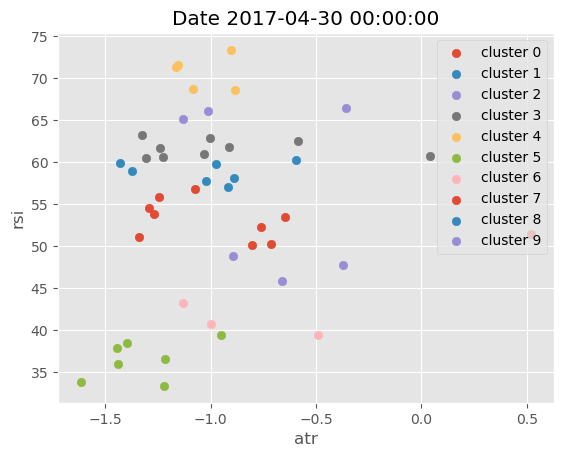

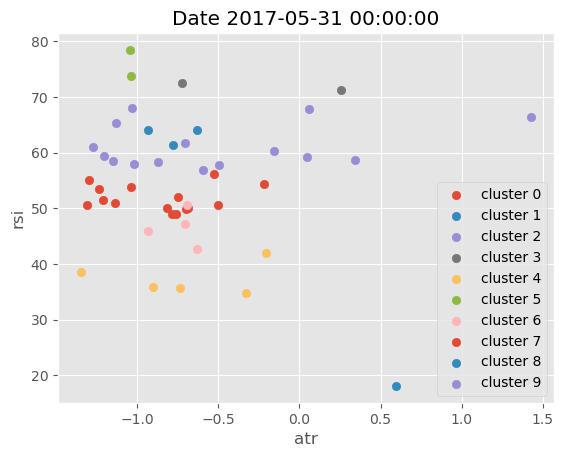

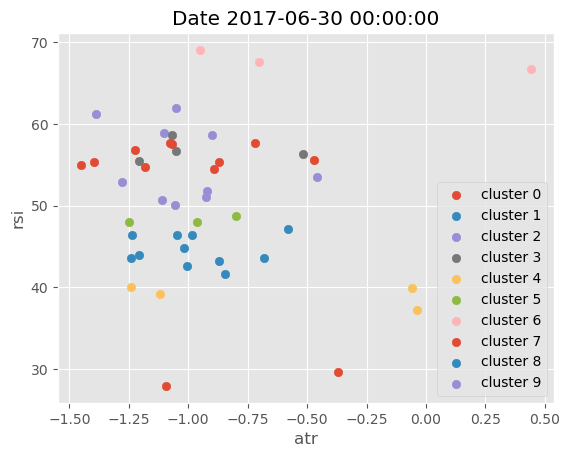

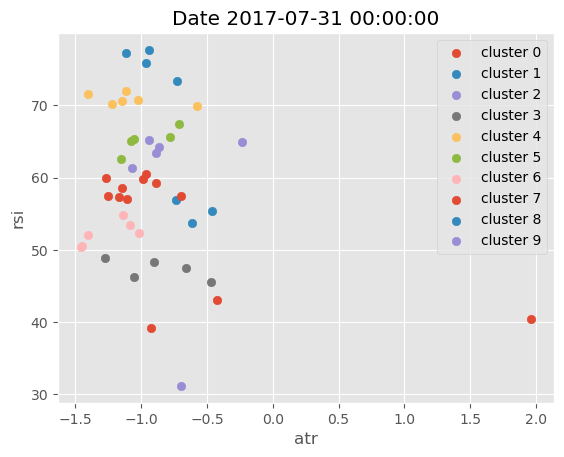

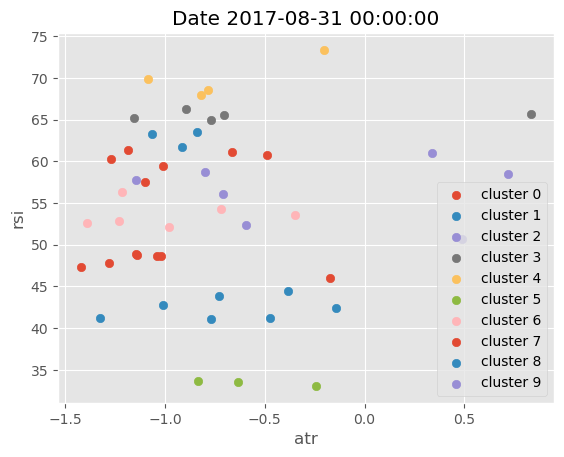

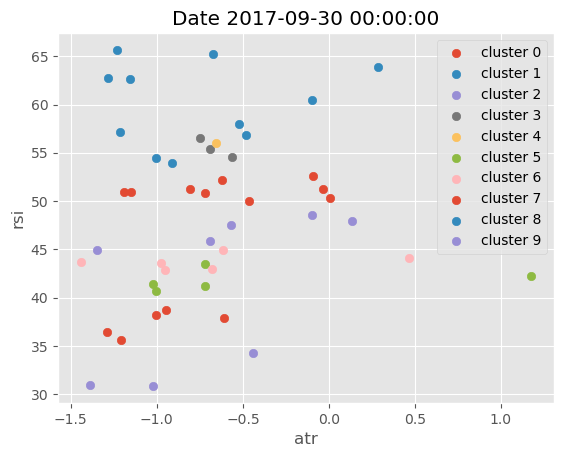

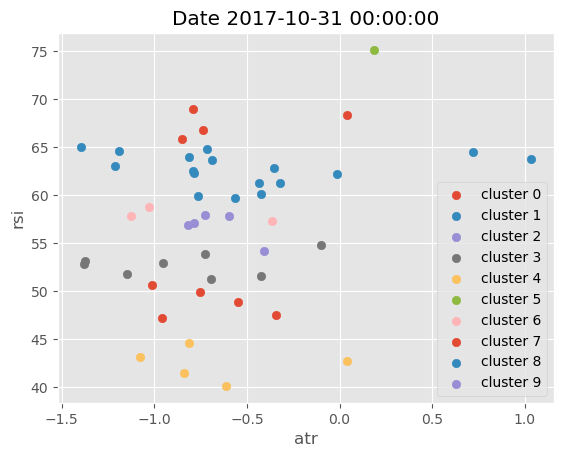

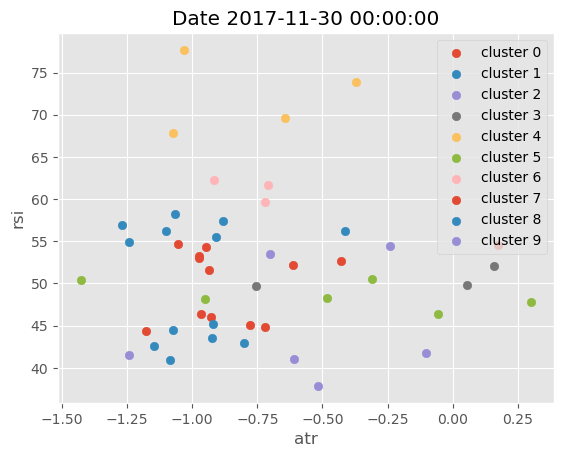

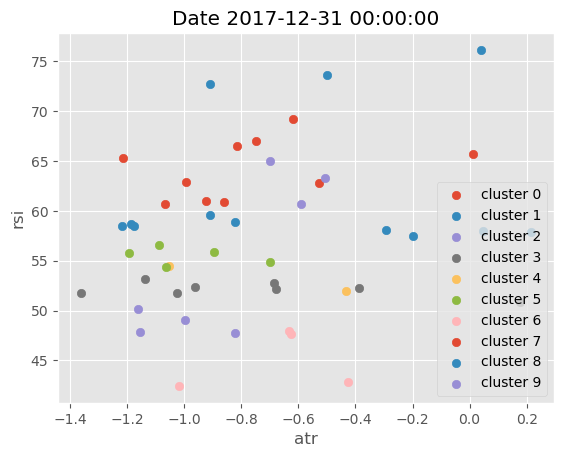

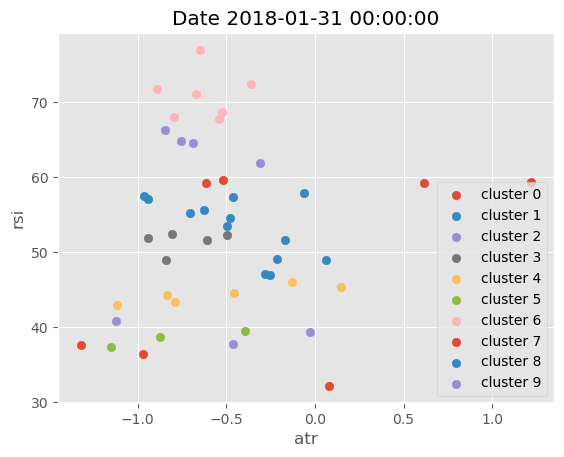

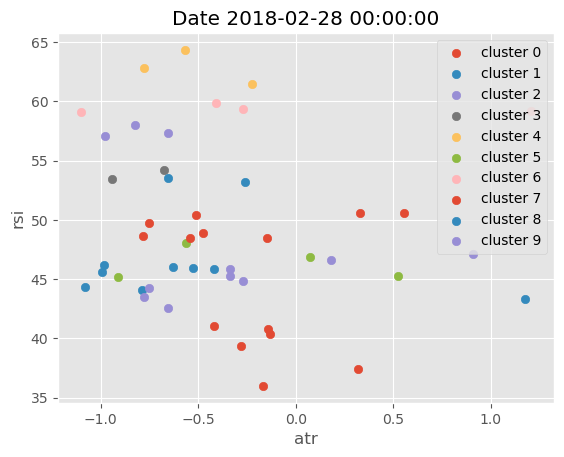

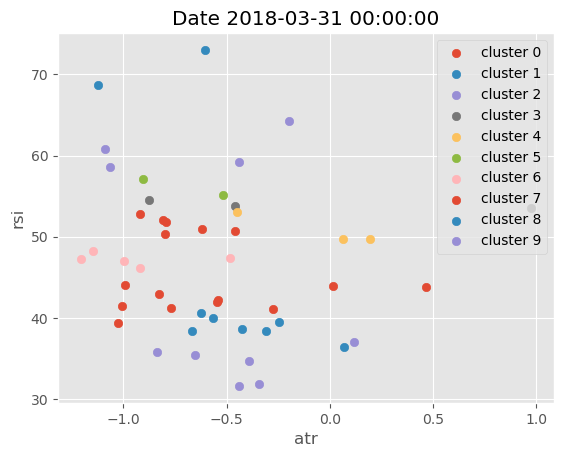

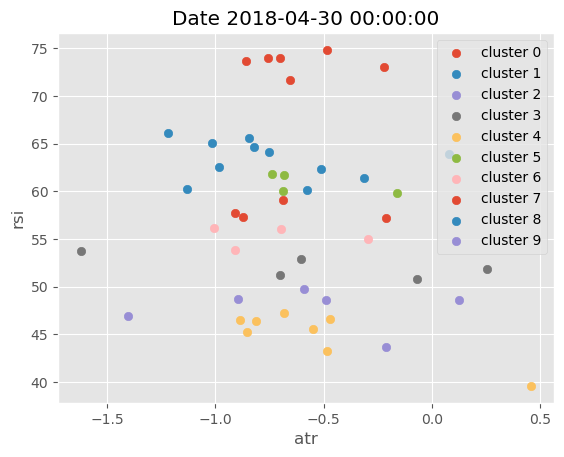

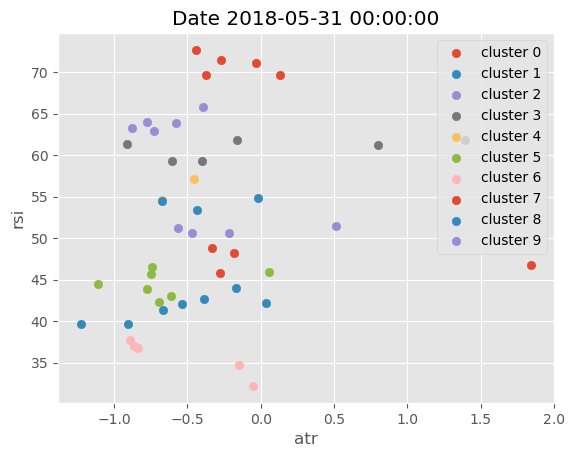

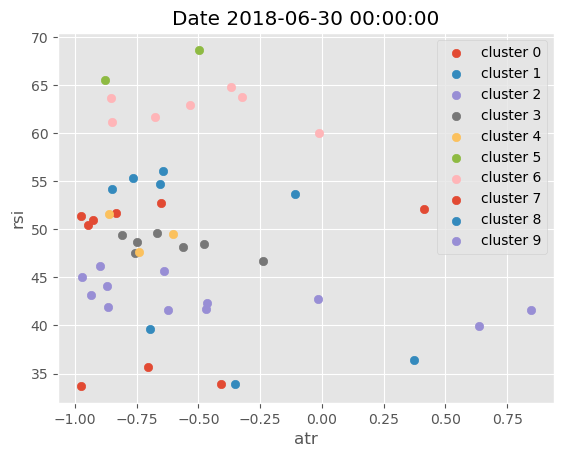

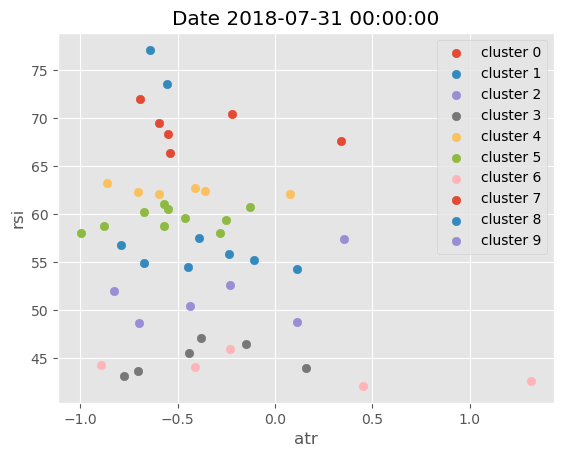

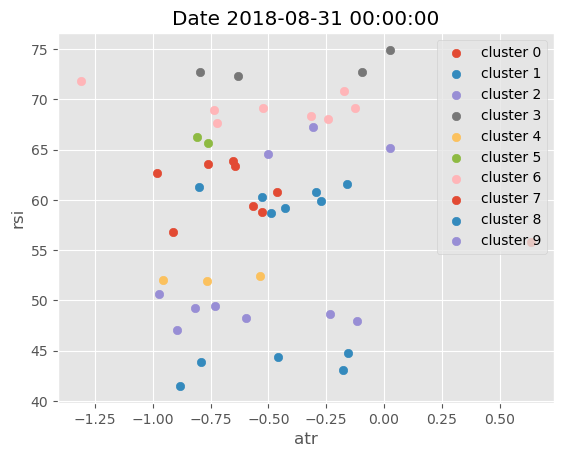

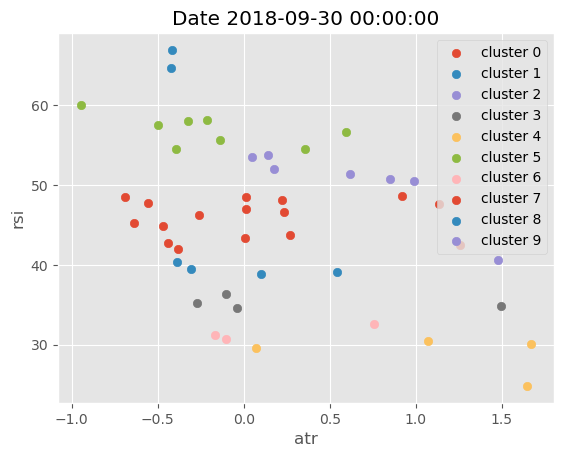

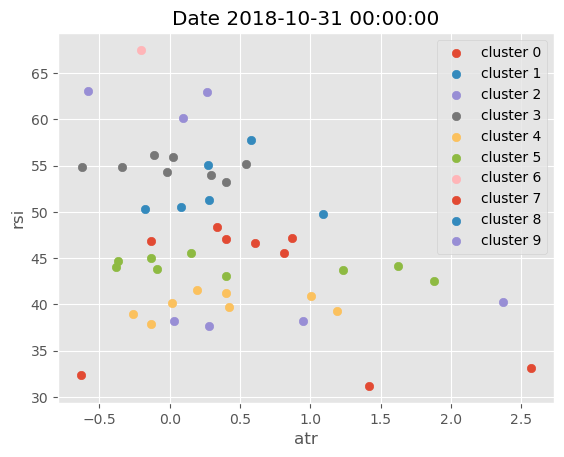

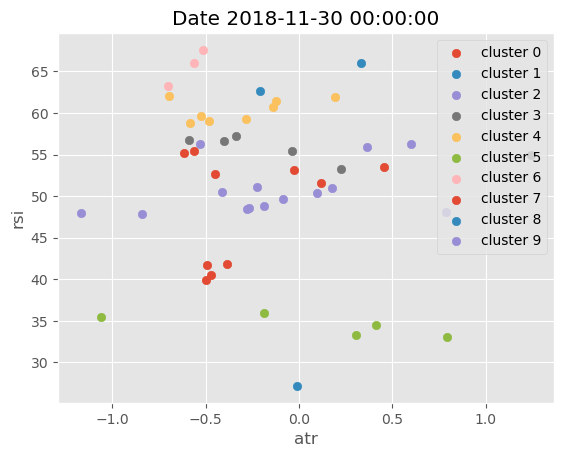

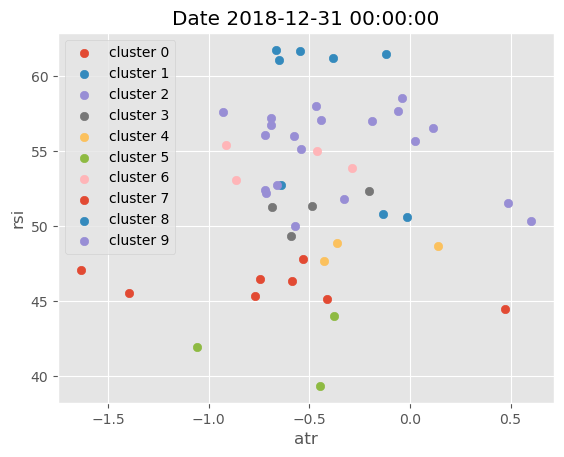

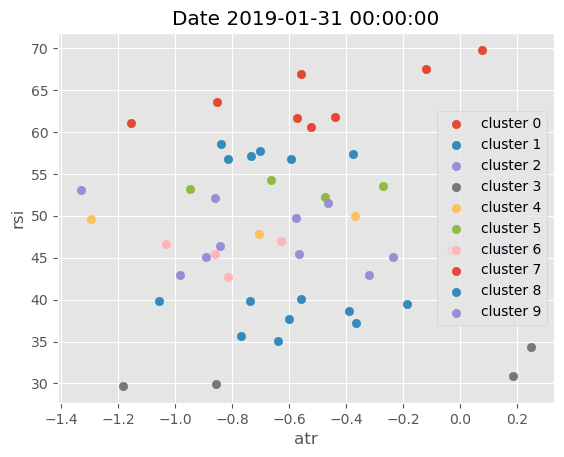

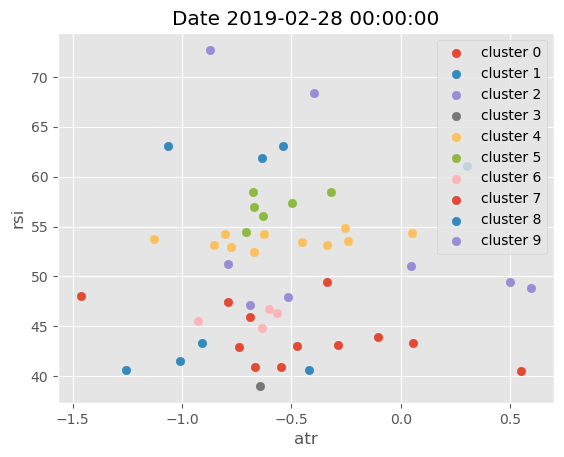

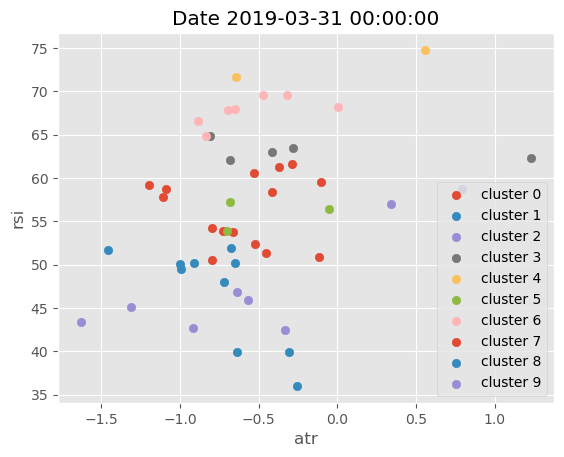

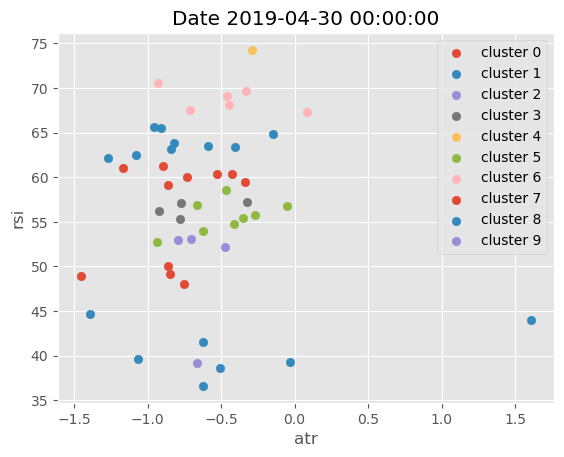

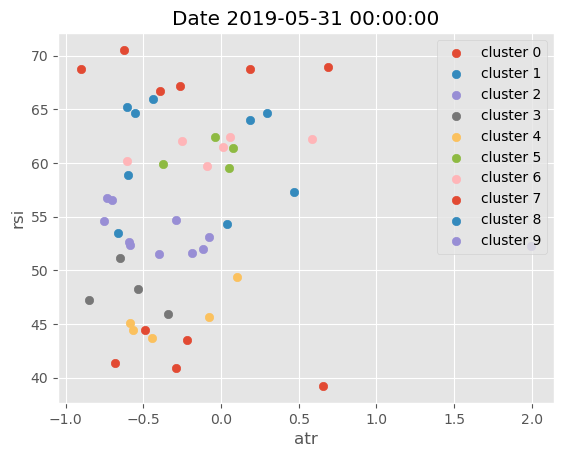

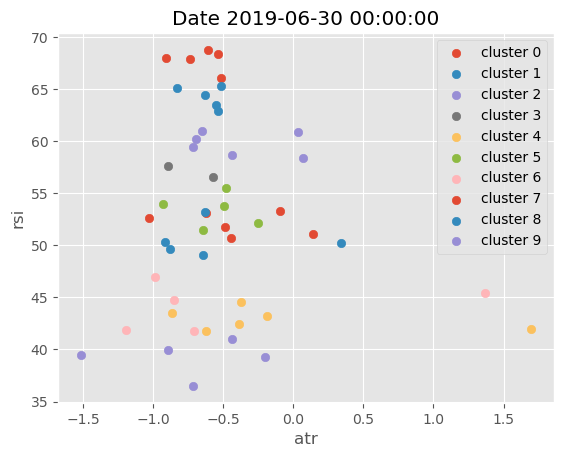

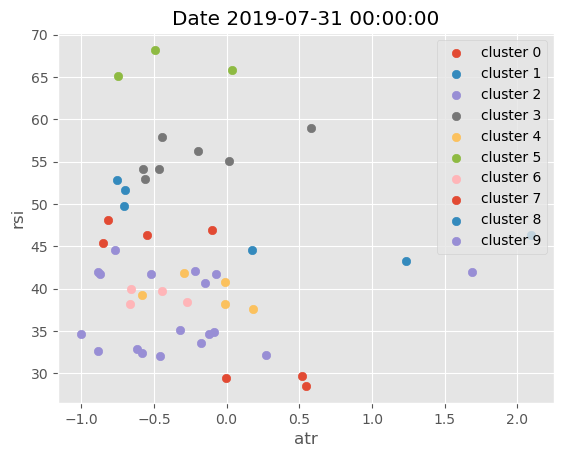

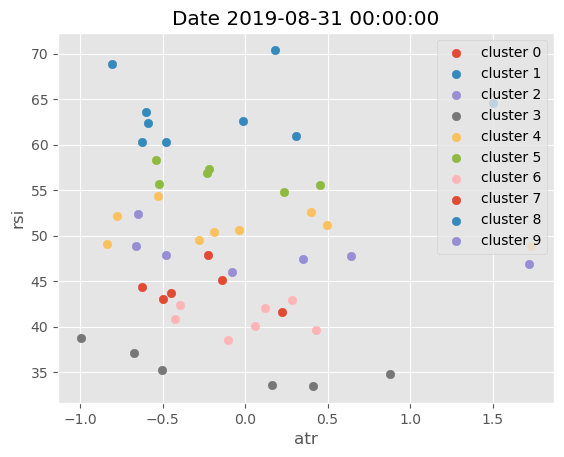

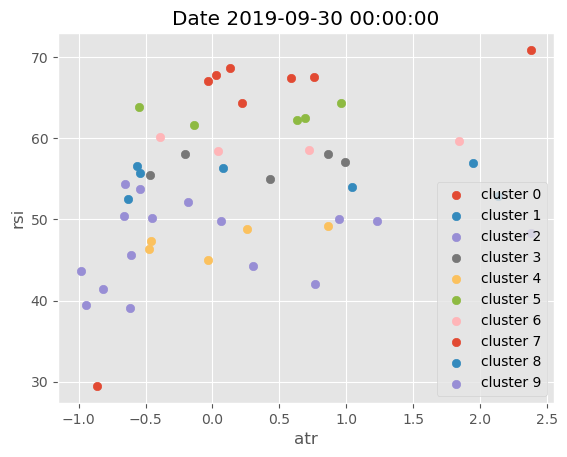

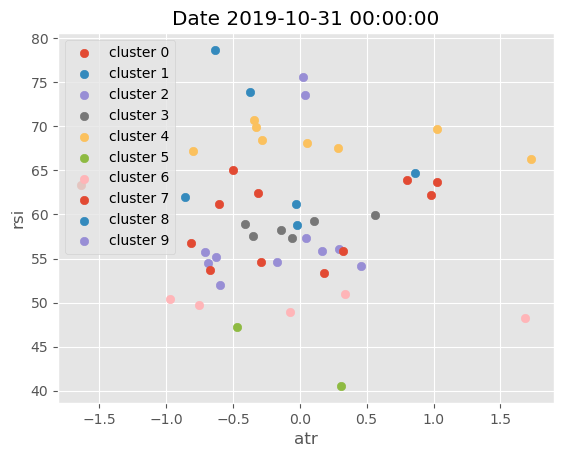

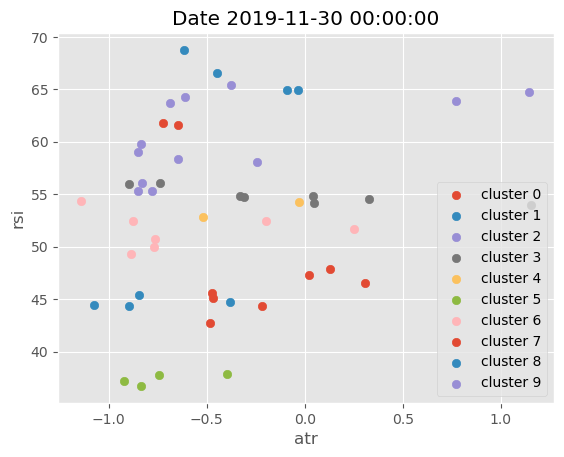

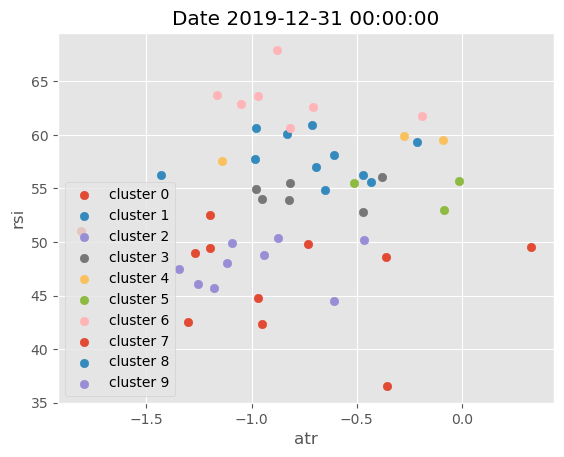

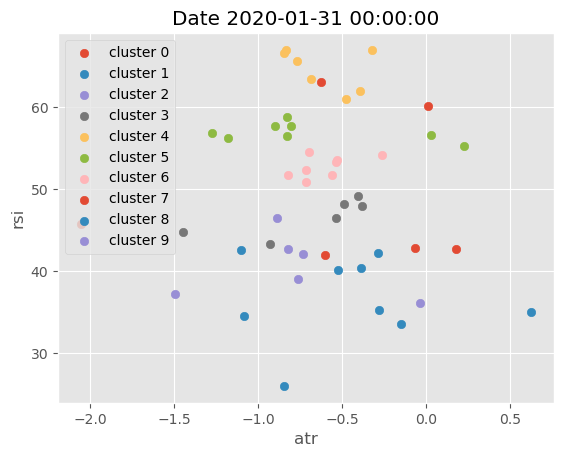

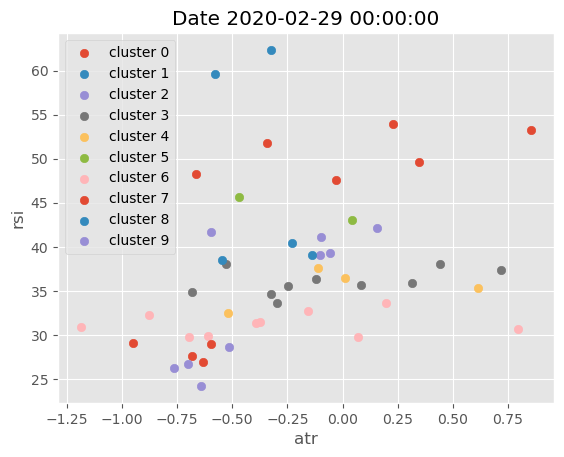

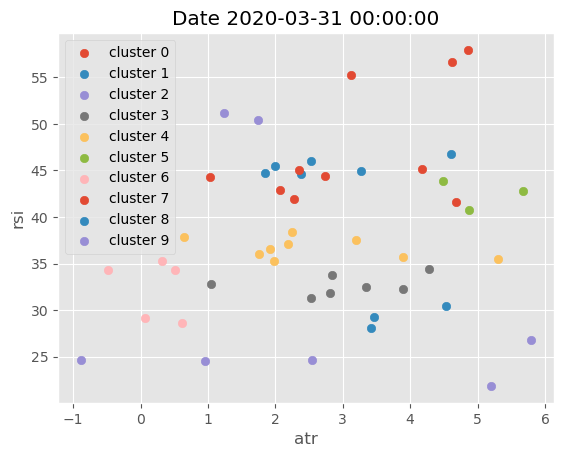

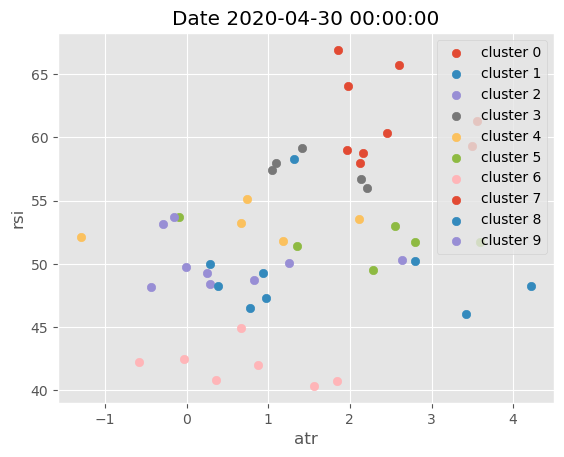

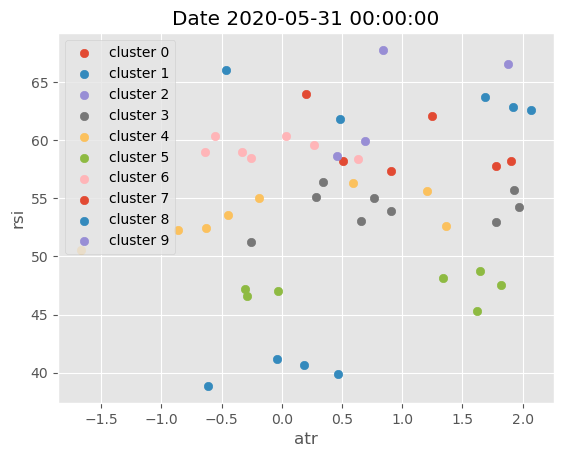

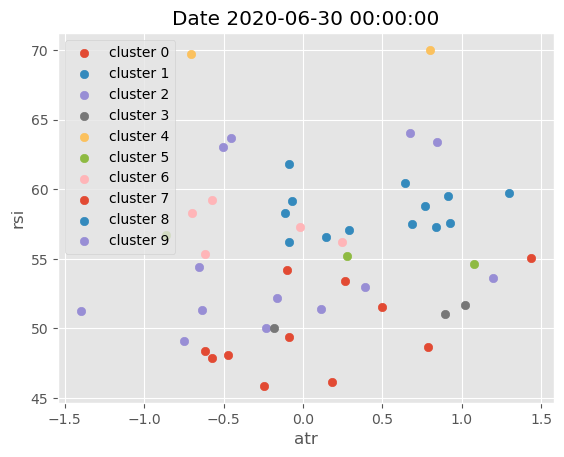

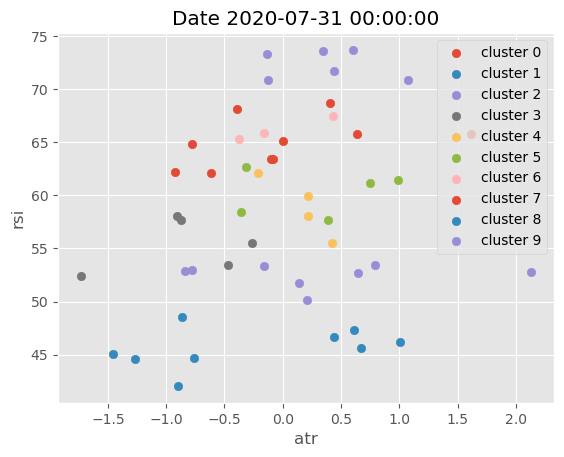

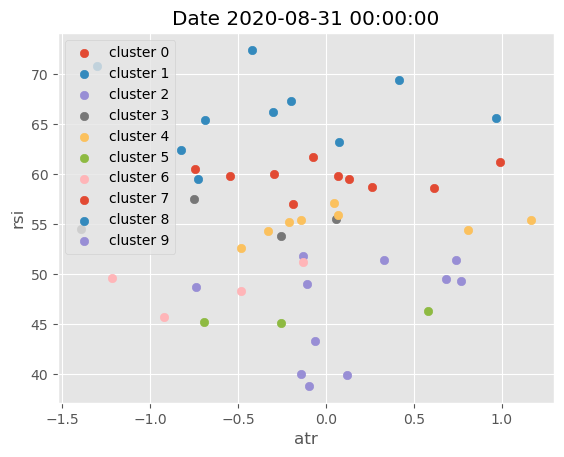

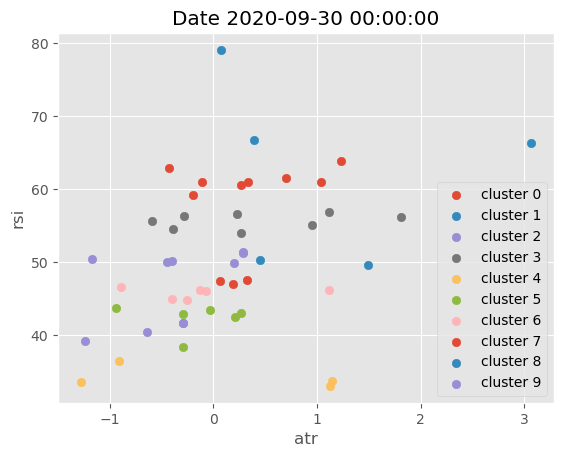

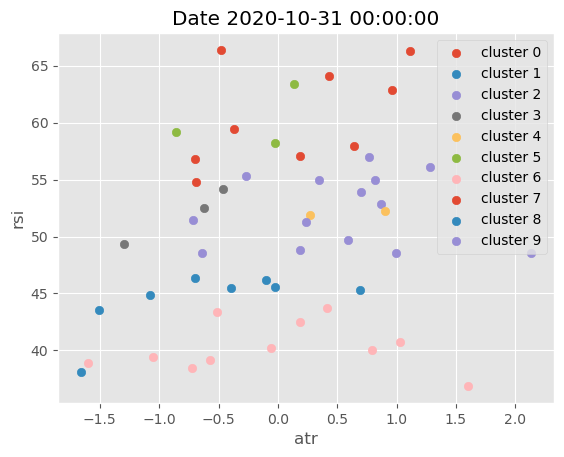

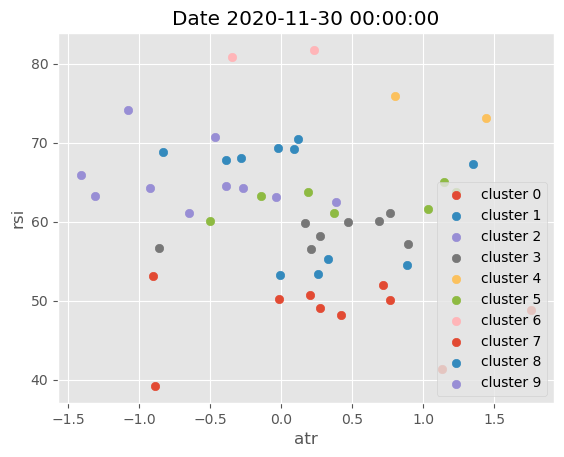

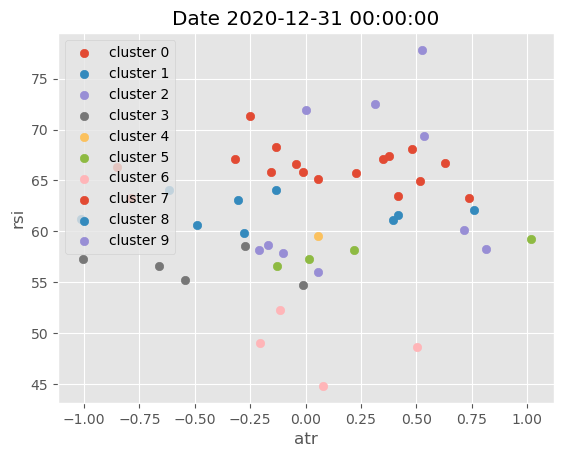

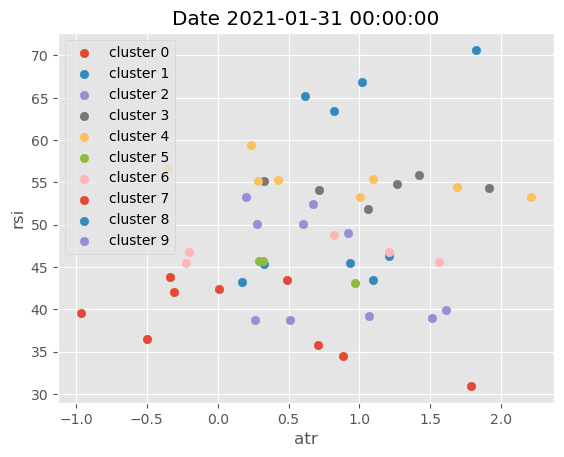

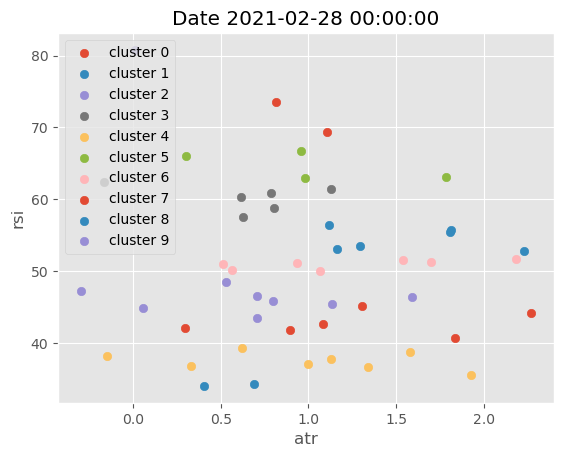

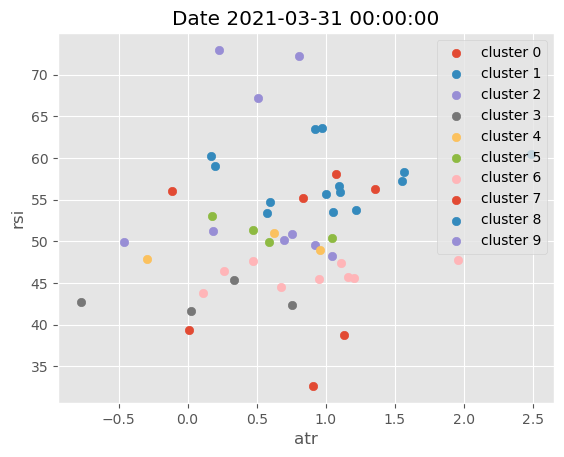

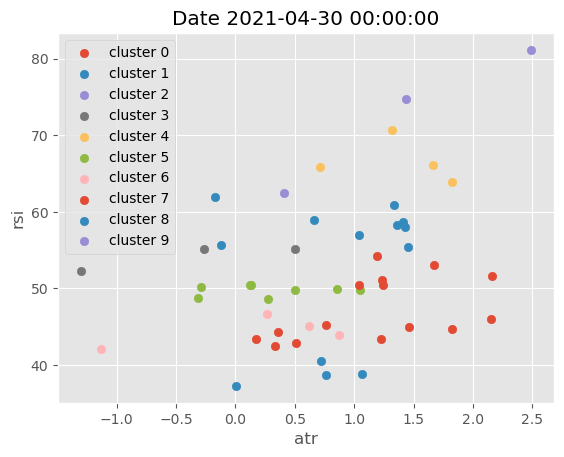

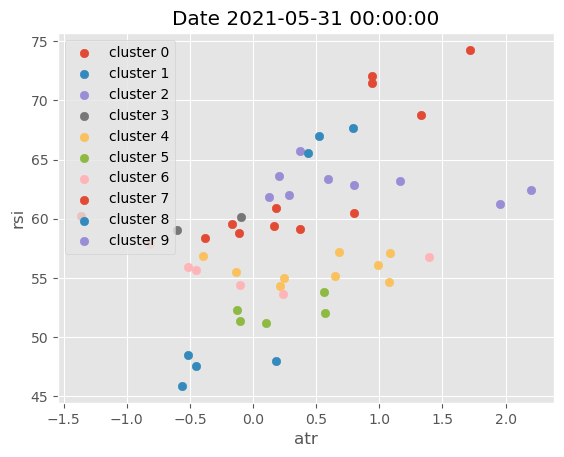

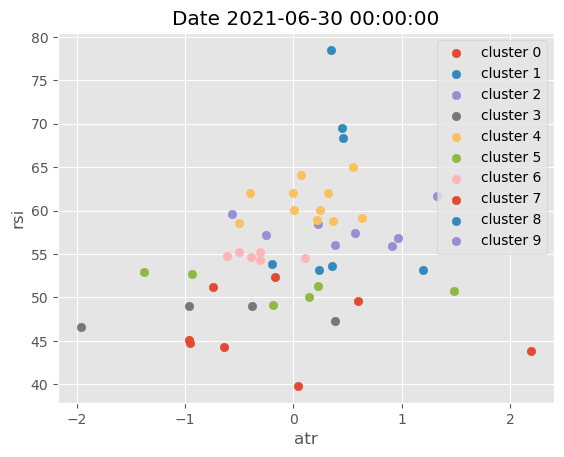

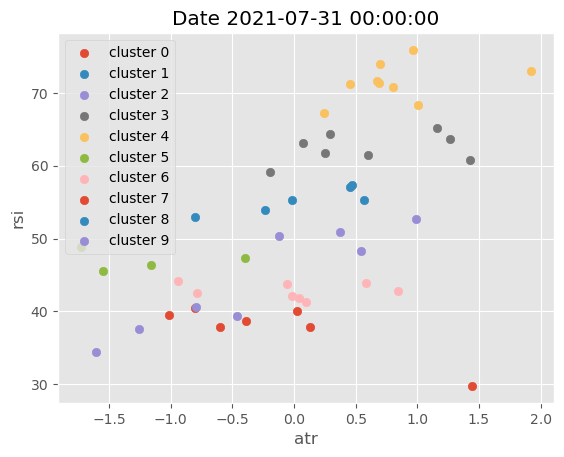

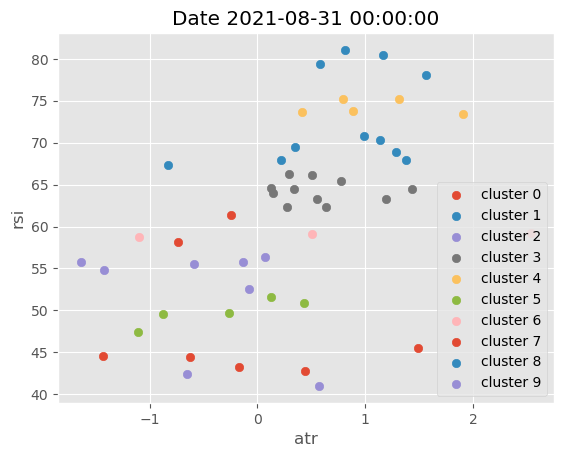

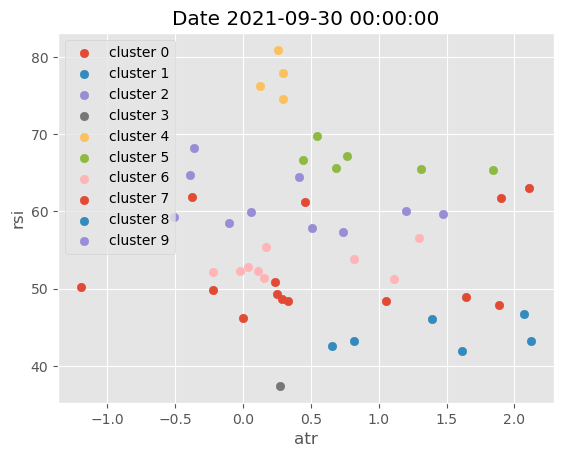

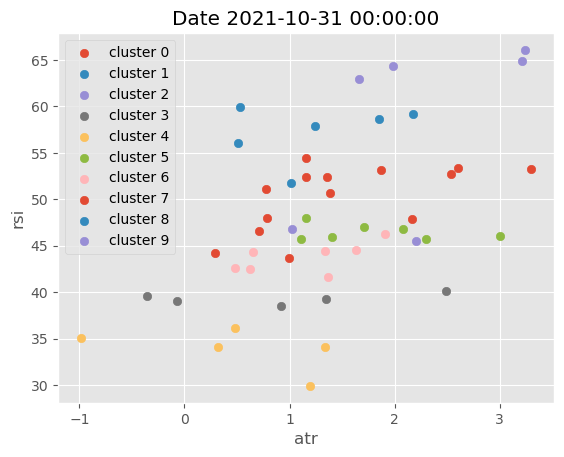

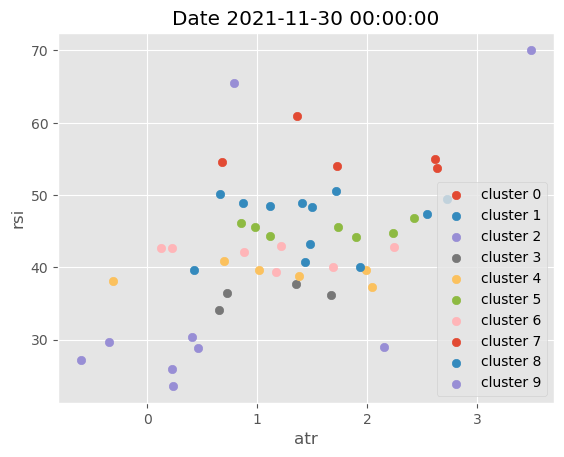

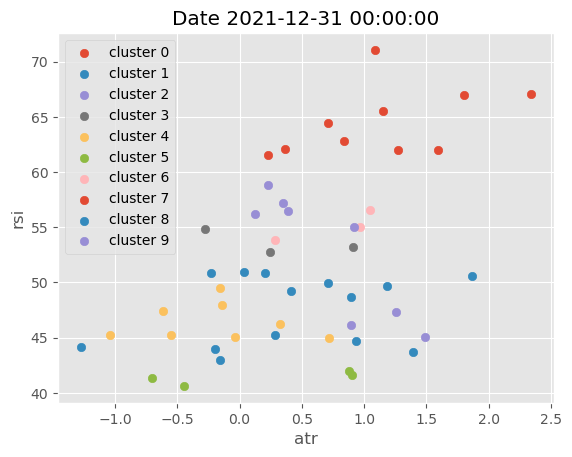

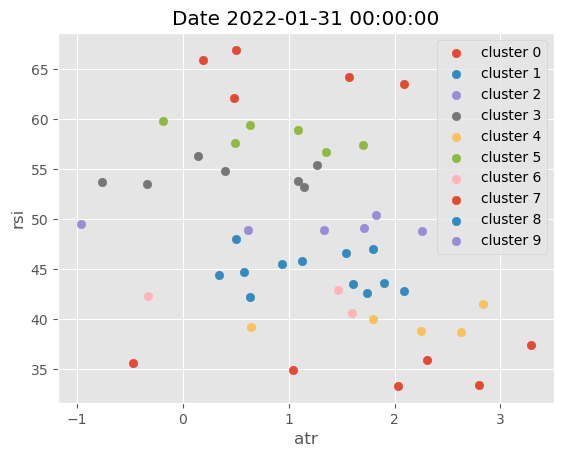

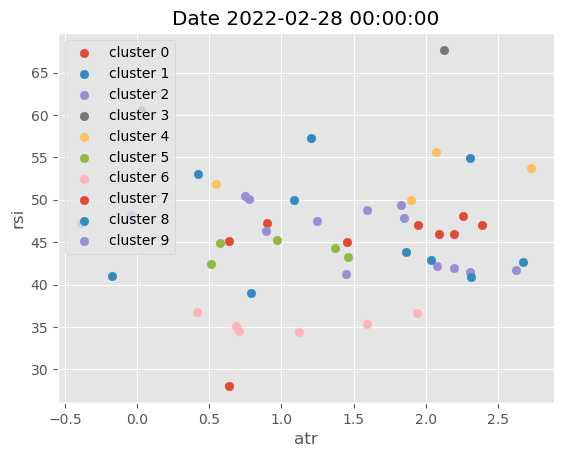

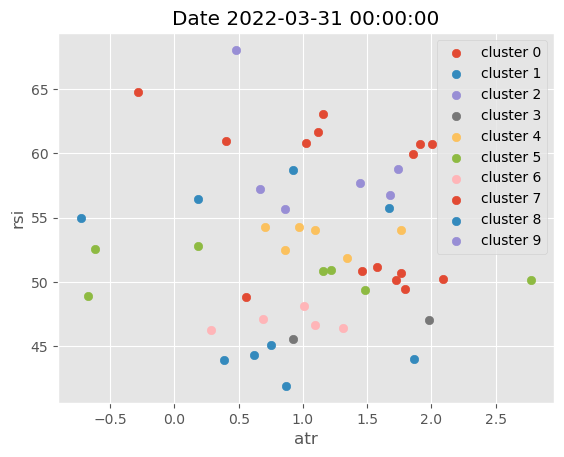

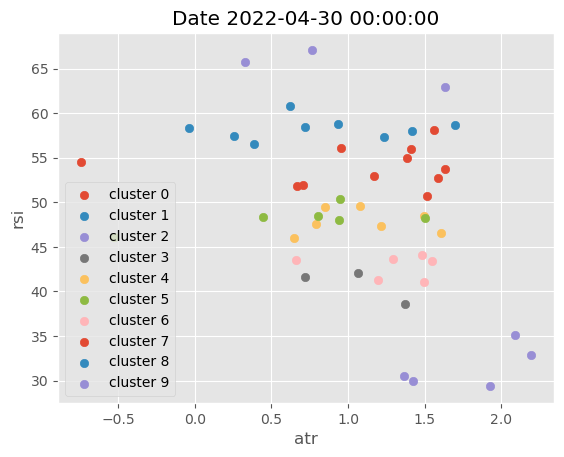

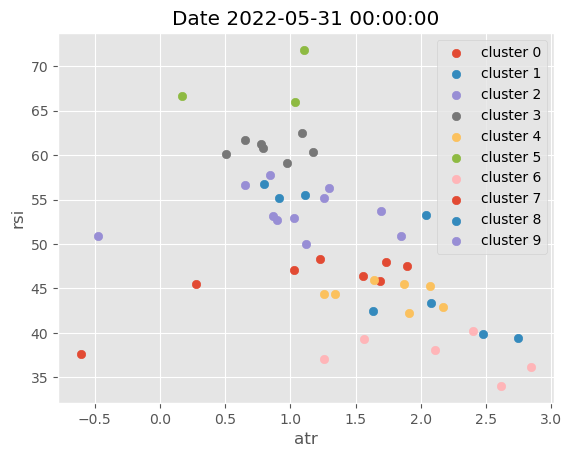

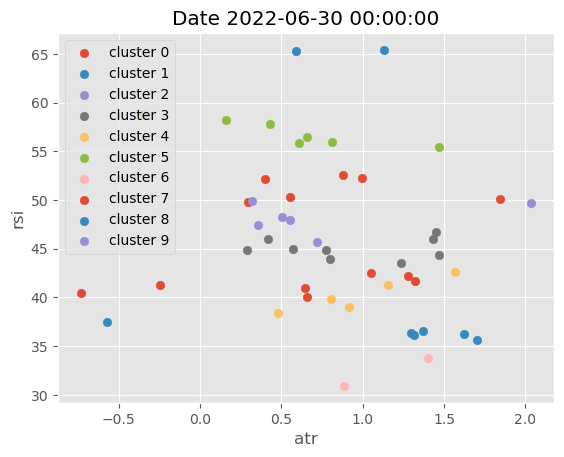

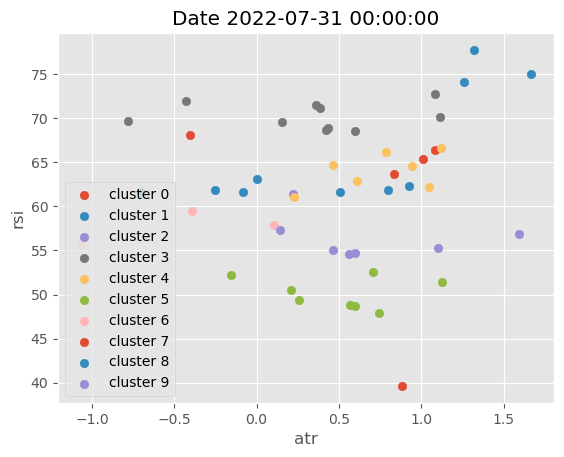

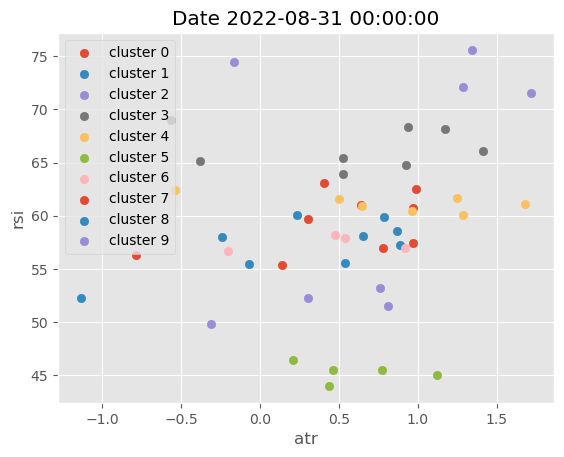

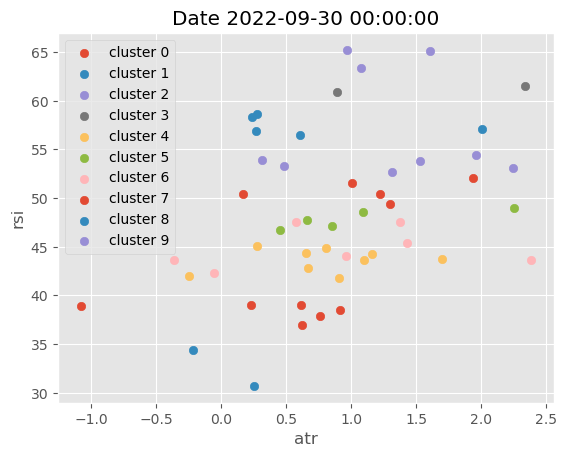

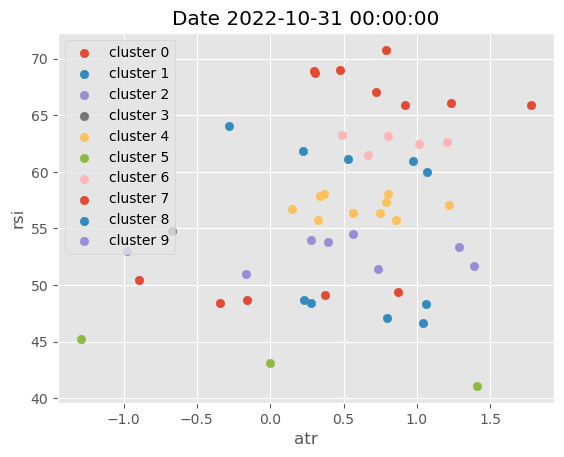

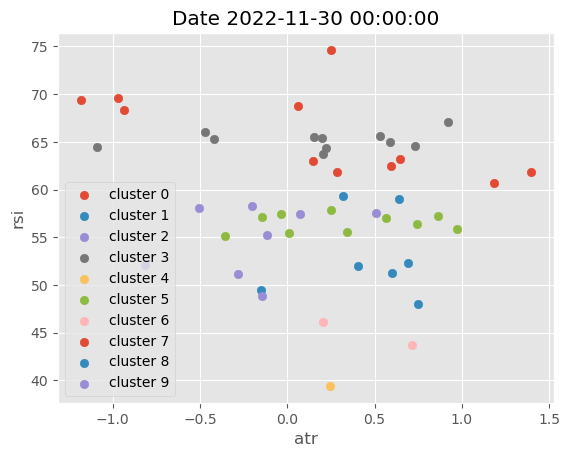

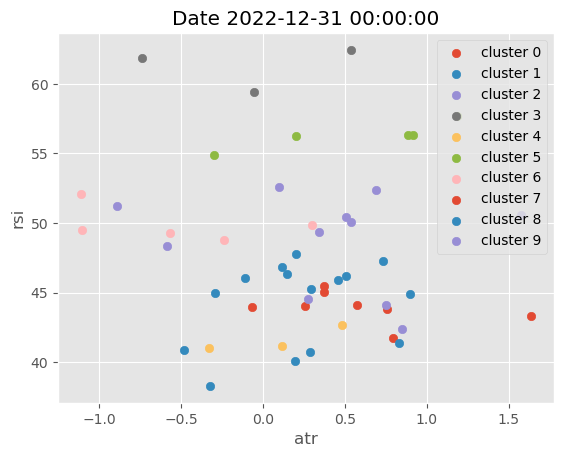

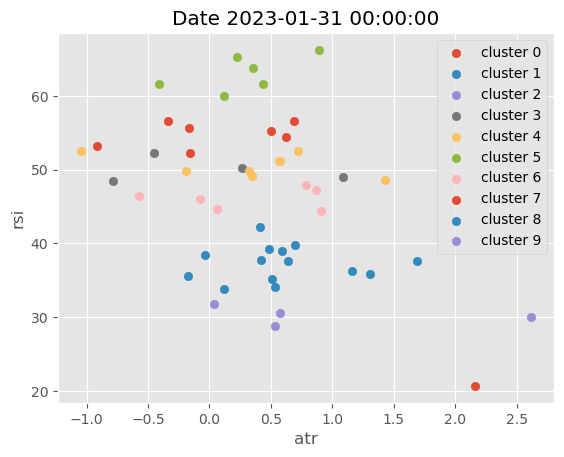

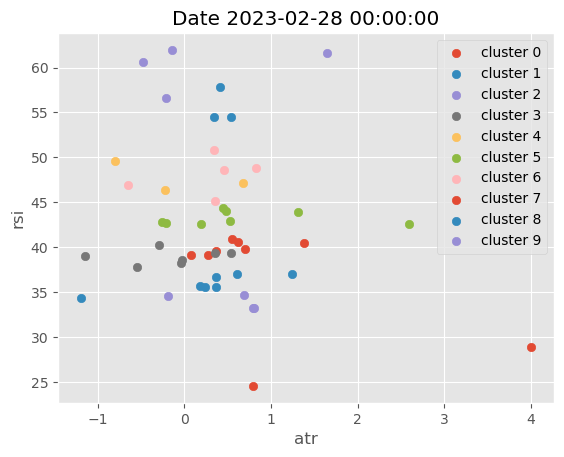

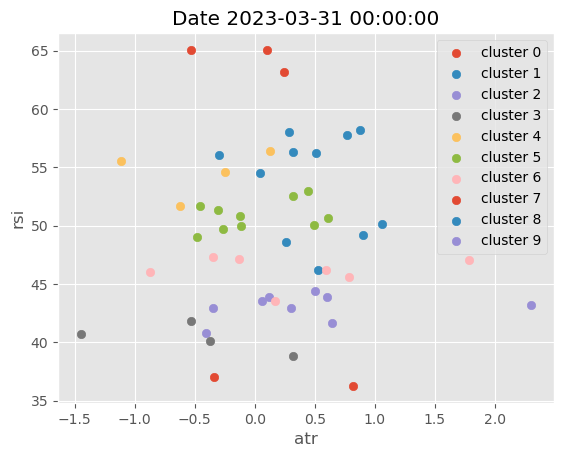

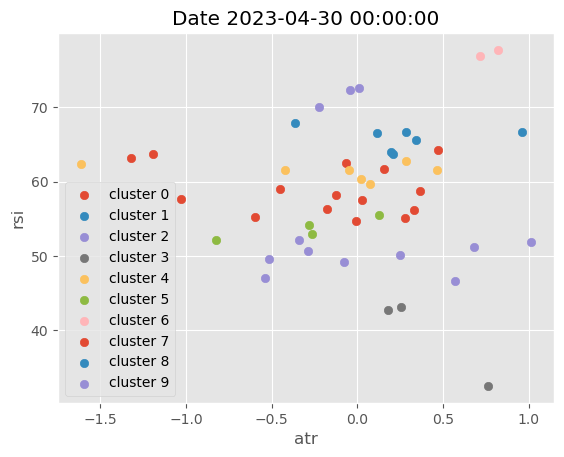

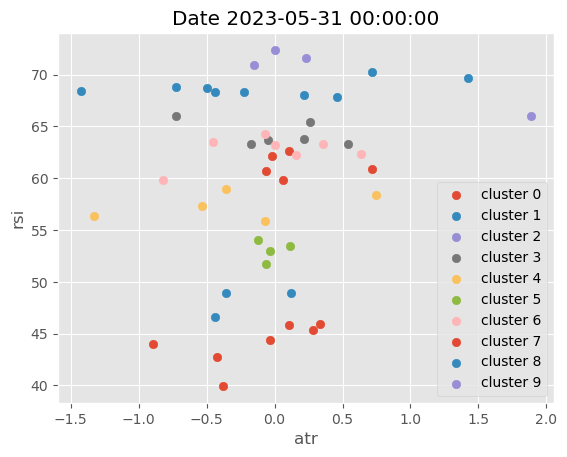

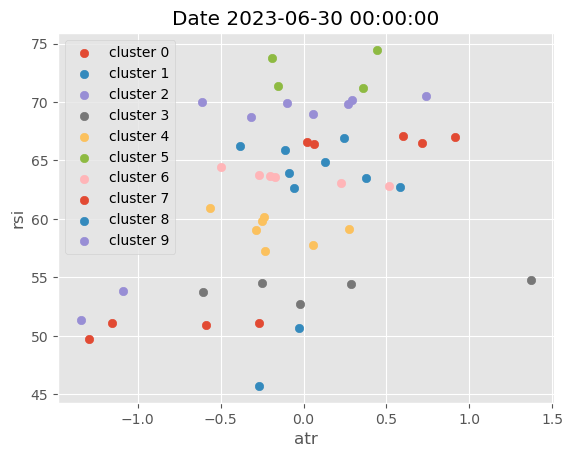

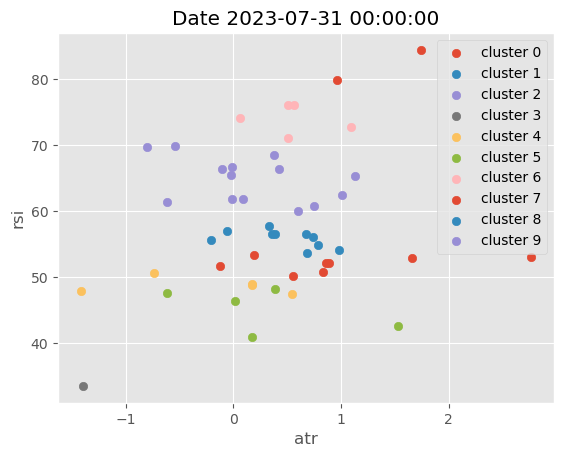

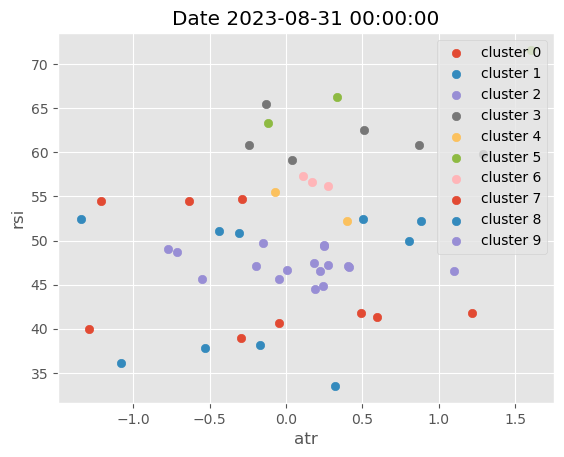

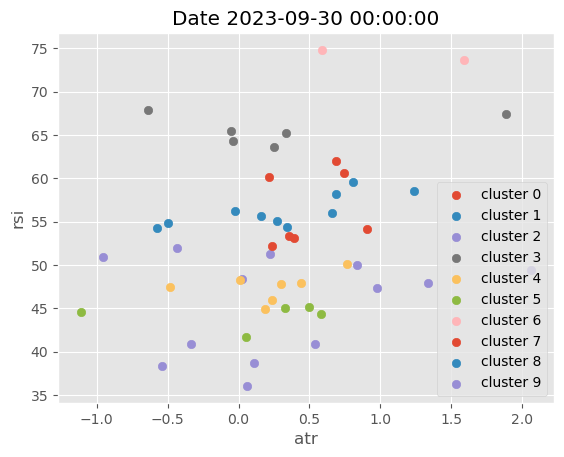

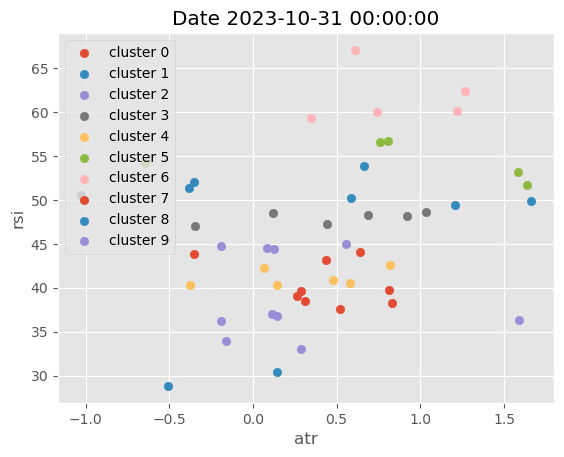

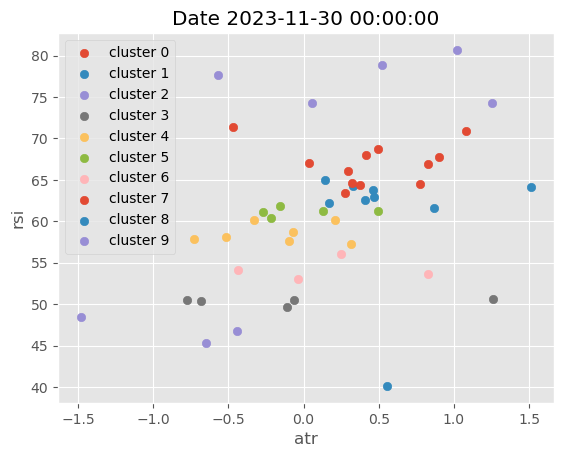

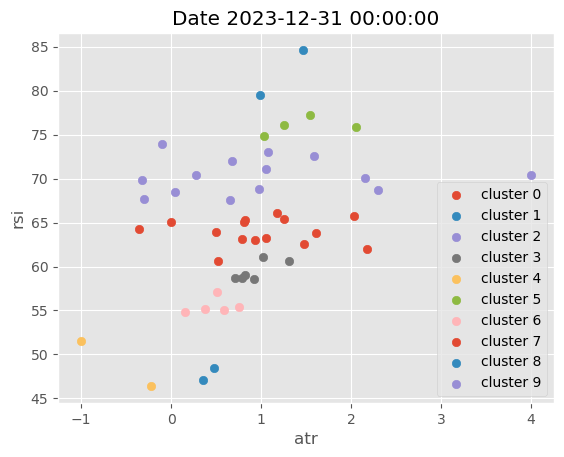

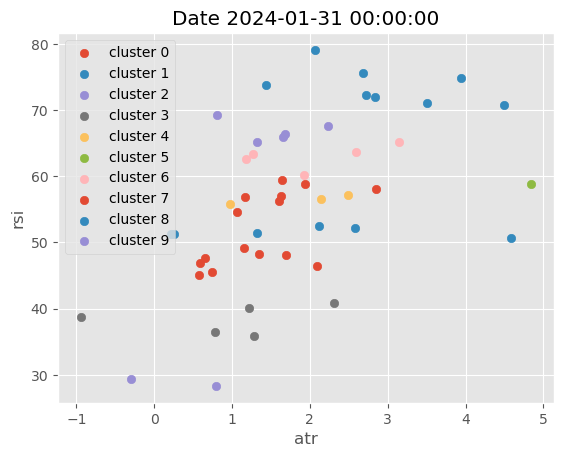

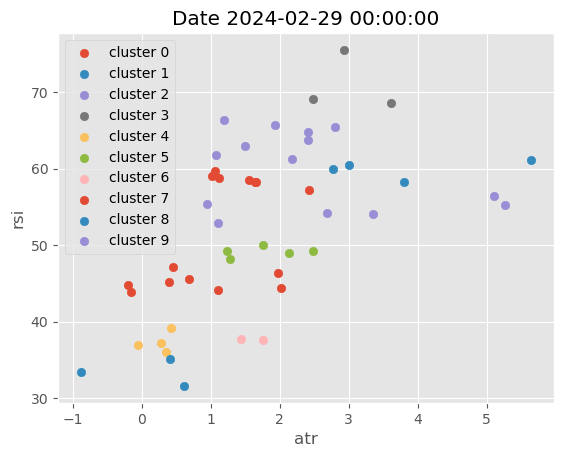

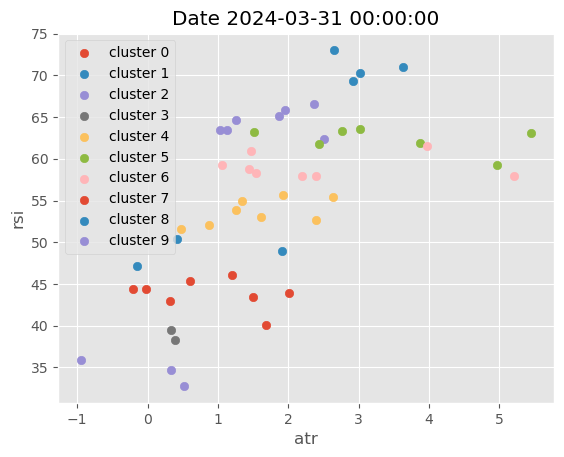

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [16]:
target_rsi_values = [30,35,40,45,55,60,65,70,75,80]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 80.,  0.,  0.,  0.,  0.,

In [17]:
 

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=10,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-04-30 ADANIENT.NS            0.001972  45.796896  3.972978  4.206242   
           ADANIPORTS.NS         -0.000162  52.271725  5.702974  5.772705   
           APOLLOHOSP.NS         -0.000084  57.725902  7.002435  7.045234   
           ASIANPAINT.NS         -0.000292  65.115049  6.900091  6.936196   
           AXISBANK.NS            0.000178  53.415713  6.176689  6.210429   
...                                    ...        ...       ...       ...   
2024-03-31 TECHM.NS               0.000056  45.308404  7.147596  7.177232   
           TITAN.NS               0.000278  57.901359  8.164501  8.195490   
           ULTRACEMCO.NS          0.000208  55.710372  9.184813  9.205351   
           UPL.NS                 0.000101  35.886913  6.129151  6.177267   
           WIPRO.NS               0.000092  58.720675  6.179884  6.247646   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-04-30 ADANIENT.NS    4.439506 -0.661206 -0.118727   0.003685   0.051709   
           ADANIPORTS.NS  5.842436 -0.761897 -0.171954  -0.035041   0.042112   
           APOLLOHOSP.NS  7.088033 -1.022055 -0.221959   0.058447  -0.026629   
           ASIANPAINT.NS  6.972302 -1.132552  0.137166   0.043735   0.045933   
           AXISBANK.NS    6.244168 -0.646374 -0.044190   0.038407   0.002956   
...                            ...       ...       ...        ...        ...   
2024-03-31 TECHM.NS       7.206867  0.606050 -0.531336  -0.001609  -0.023464   
           TITAN.NS       8.226478  2.399310 -0.268556   0.039041   0.009200   
           ULTRACEMCO.NS  9.225890  1.925823 -0.189835   0.024574  -0.001567   
           UPL.NS         6.225382 -0.951797 -1.155123   0.010326  -0.060556   
           WIPRO.NS       6.315408  1.446324  1.511336   0.000964   0.041942   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-04-30 ADANIENT.NS     0.077259   0.084676   0.033984    0.019219   
           ADANIPORTS.NS   0.037600   0.010934   0.038920    0.026939   
           APOLLOHOSP.NS   0.000866  -0.013741  -0.010965   -0.005155   
           ASIANPAINT.NS   0.048985   0.008140   0.000902    0.022339   
           AXISBANK.NS     0.030296   0.007640  -0.007656    0.007126   
...                             ...        ...        ...         ...   
2024-03-31 TECHM.NS       -0.000223   0.008370   0.020213    0.017322   
           TITAN.NS        0.008137   0.030277   0.024160    0.034497   
           ULTRACEMCO.NS  -0.011804   0.034799   0.023037    0.024422   
           UPL.NS         -0.068564  -0.042613  -0.038622   -0.032569   
           WIPRO.NS        0.033458   0.042156   0.032777    0.029909   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-04-30 ADANIENT.NS    0.378434 -0.491834  0.323724  1.837873 -0.472962   
           ADANIPORTS.NS  0.235528  0.148918  0.474747  0.375751 -0.615782   
           APOLLOHOSP.NS  0.381067 -0.402025  0.214879 -0.201097 -1.374674   
           ASIANPAINT.NS  0.119463  0.171166  0.188263  0.416366 -0.260470   
           AXISBANK.NS    0.840137  0.206854  0.417771 -0.406144  0.041846   
...                            ...       ...       ...       ...       ...   
2024-03-31 TECHM.NS       0.693182 -0.474143  0.309465 -0.442019 -0.684713   
           TITAN.NS       0.365570  0.193260  0.340473  0.707709 -0.009373   
           ULTRACEMCO.NS  0.356428 -0.123959  0.689025  0.242540 -1.432864   
           UPL.NS         0.611083  0.210929  0.267428  0.640592  0.603537   
           WIPRO.NS       0.489302 -0.291035  0.279137 -0.074597 -0.631996   

                  

In [18]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]

#     plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

#     plt.legend()
#     plt.show()
#     return
import matplotlib.pyplot as plt

def plot_clusters(data, num_clusters=10):
    # Iterate over clusters
    for cluster_num in range(num_clusters):
        cluster_data = data[data['cluster'] == cluster_num]
        # Scatter plot for each cluster
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], label=f'cluster {cluster_num}')

    # Labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Example usage with 4 clusters
# Replace data and 'cluster' with your actual DataFrame and cluster column name
# plot_clusters(your_data_frame, num_clusters=4)


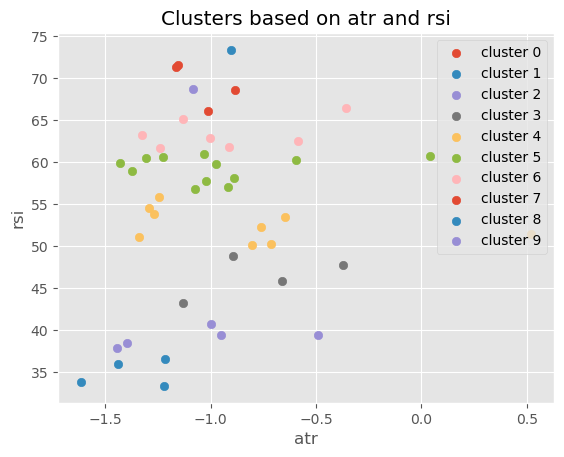

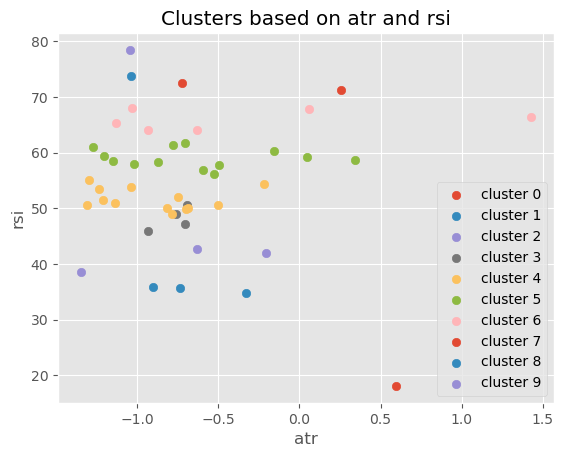

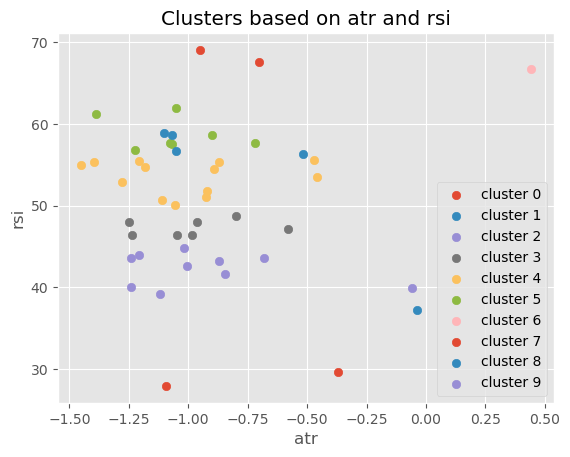

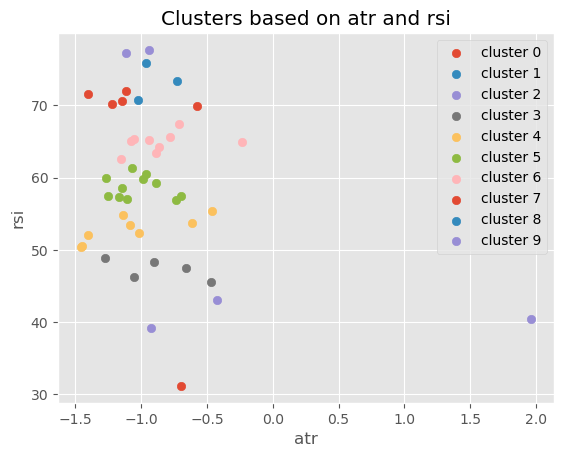

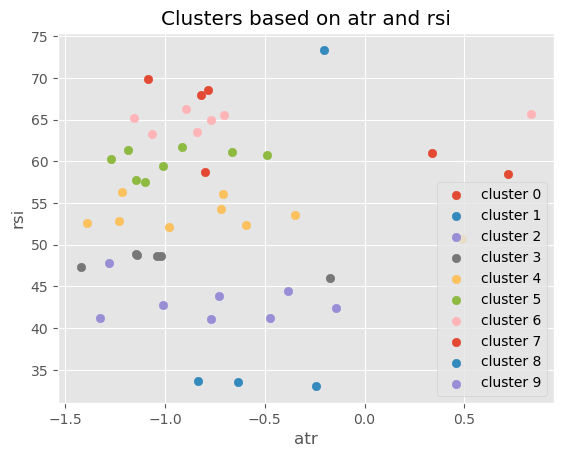

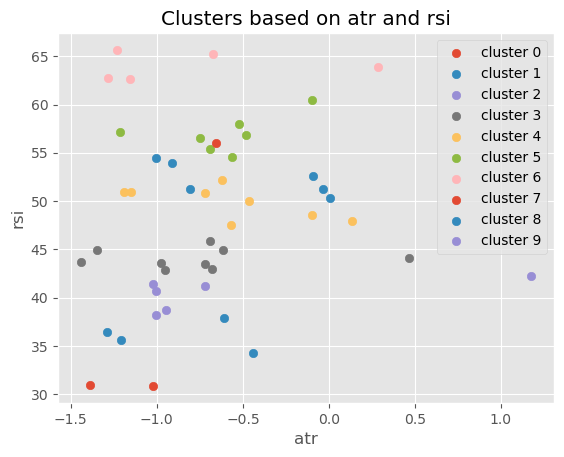

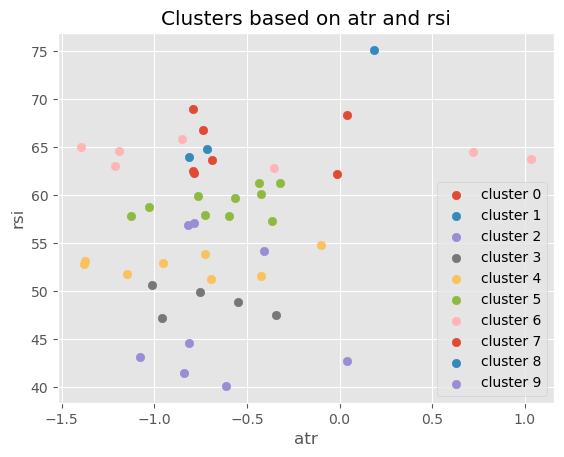

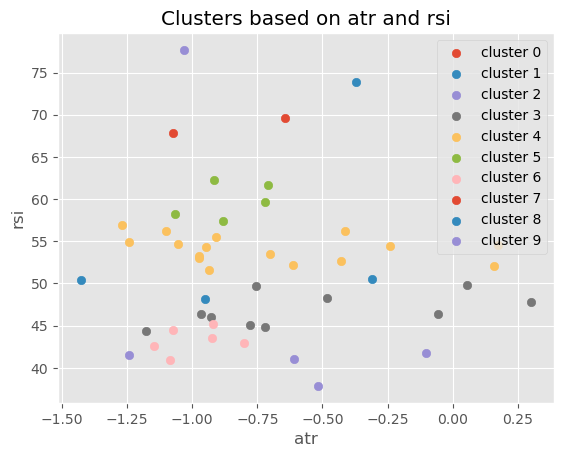

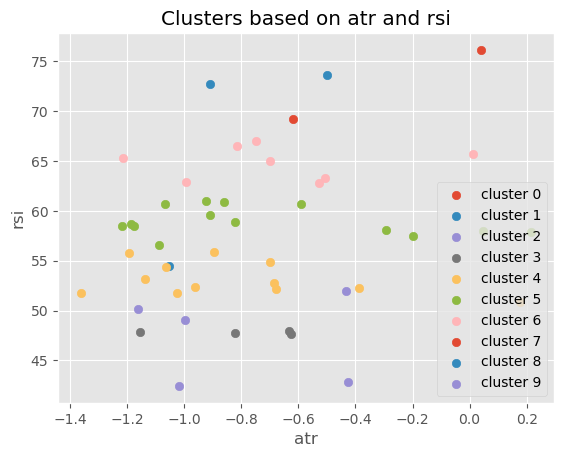

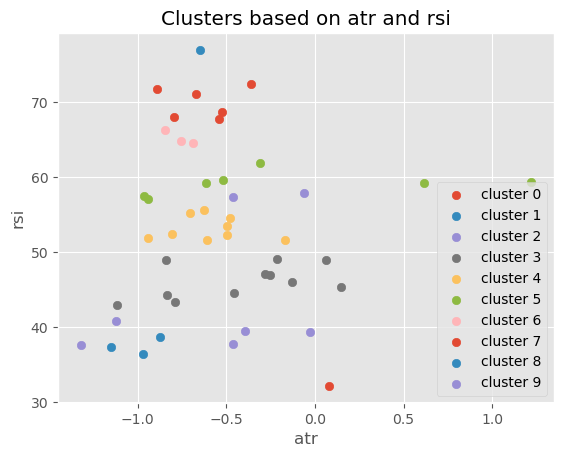

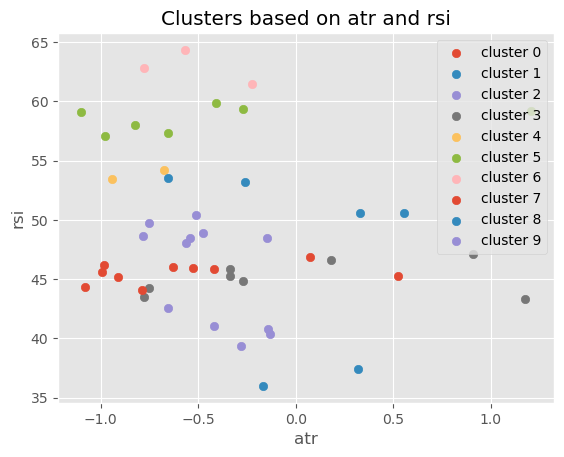

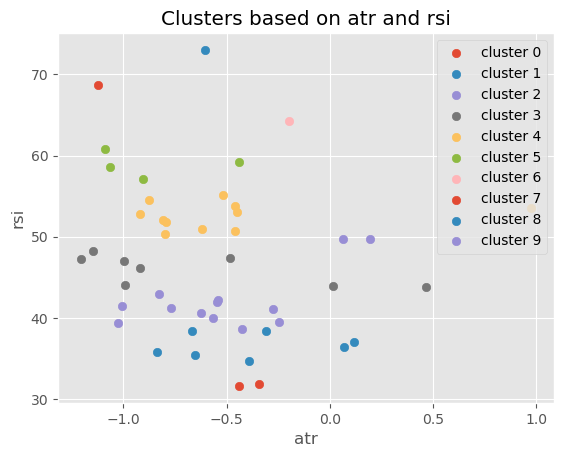

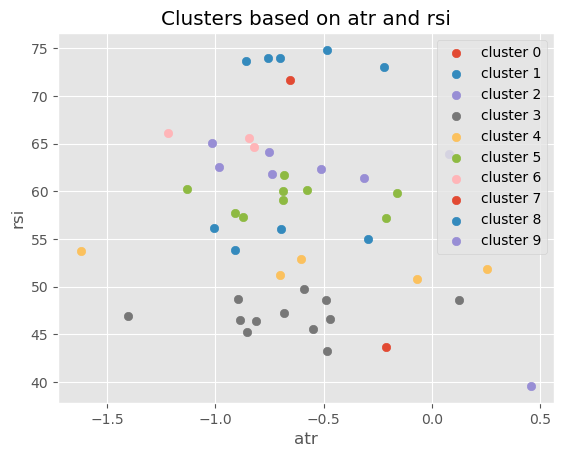

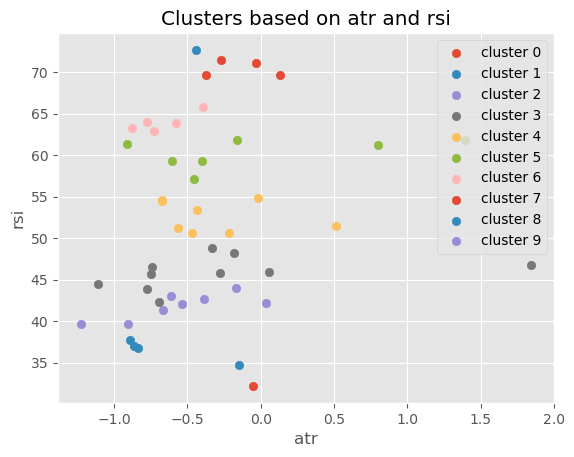

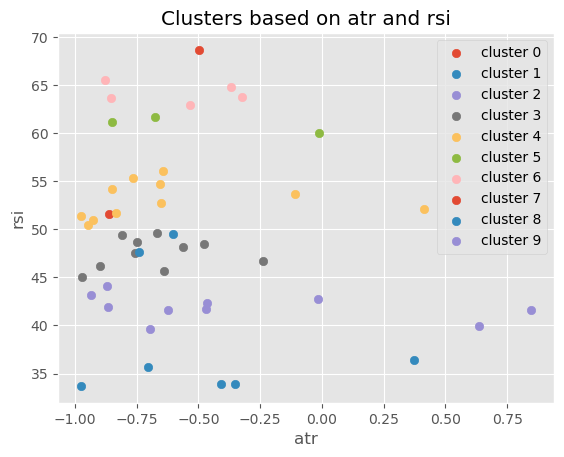

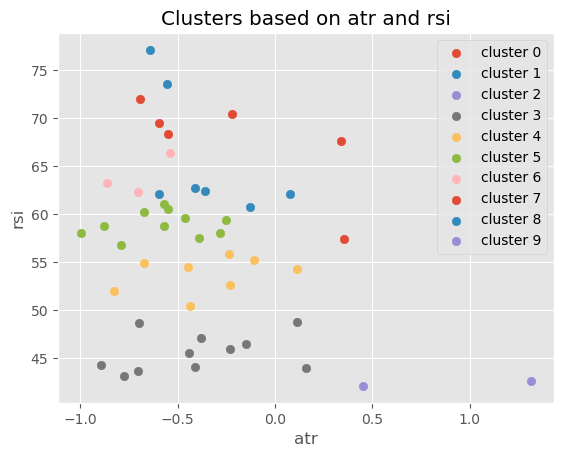

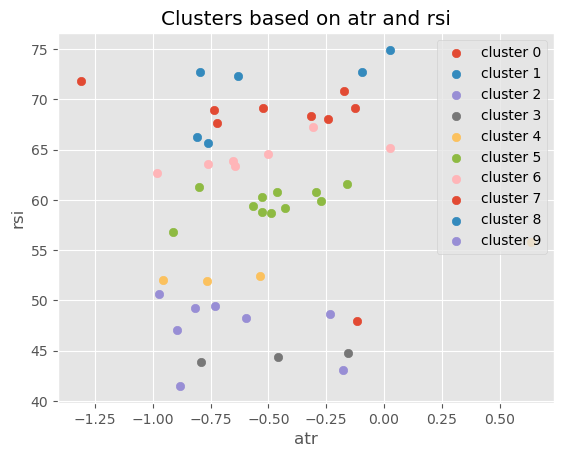

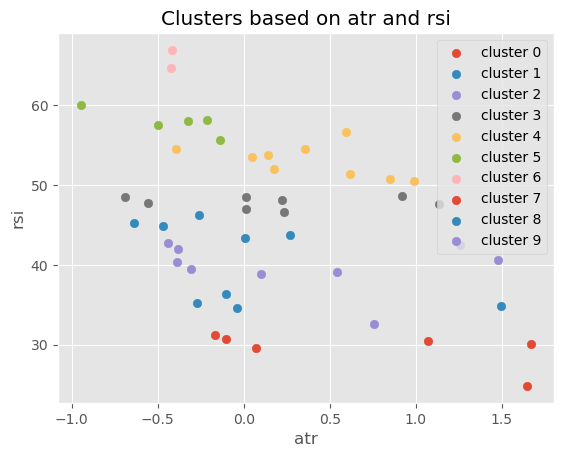

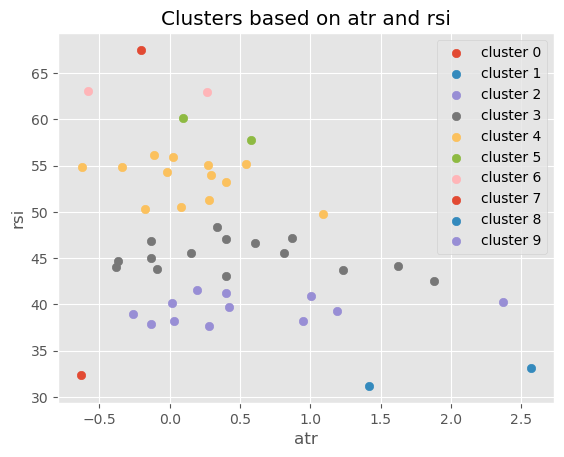

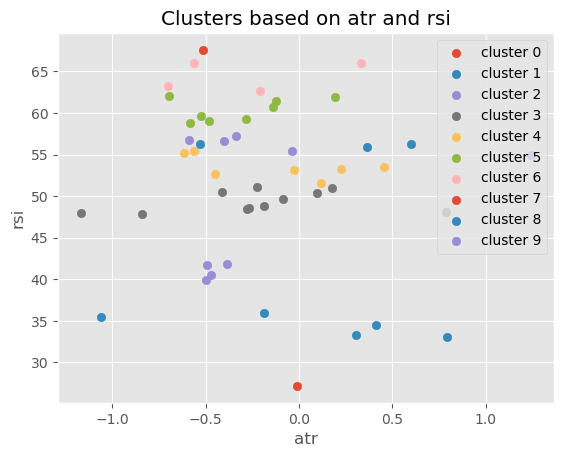

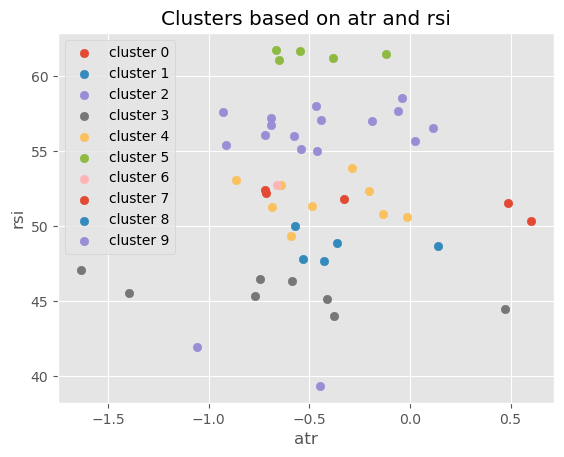

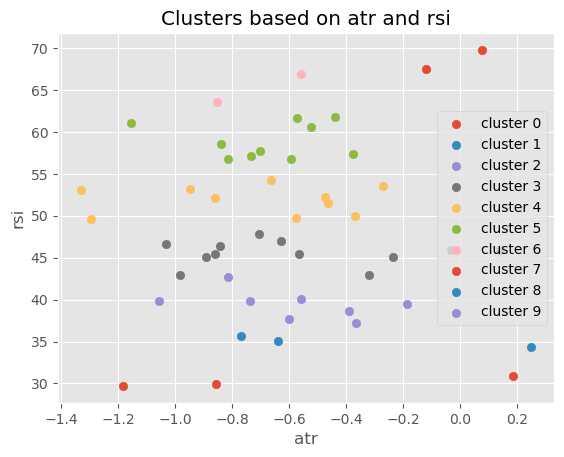

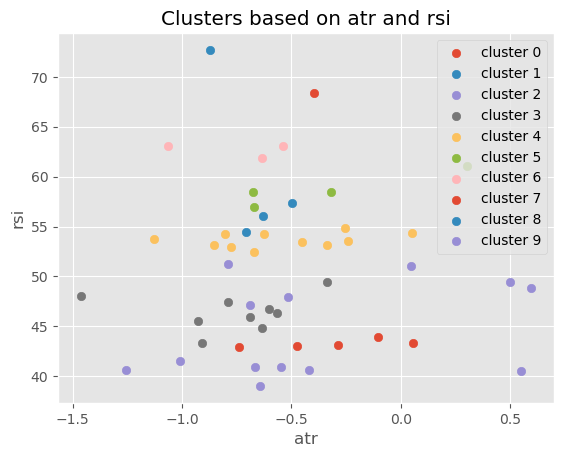

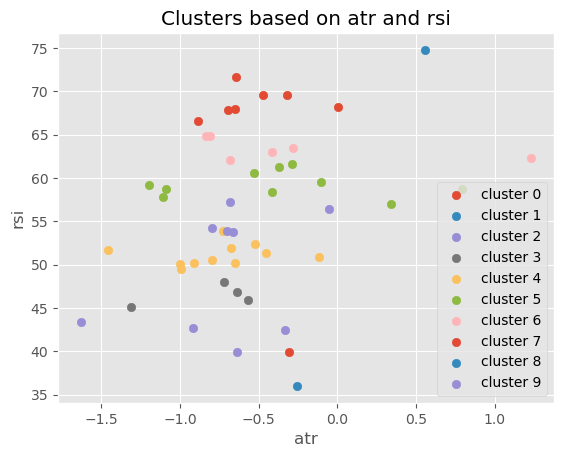

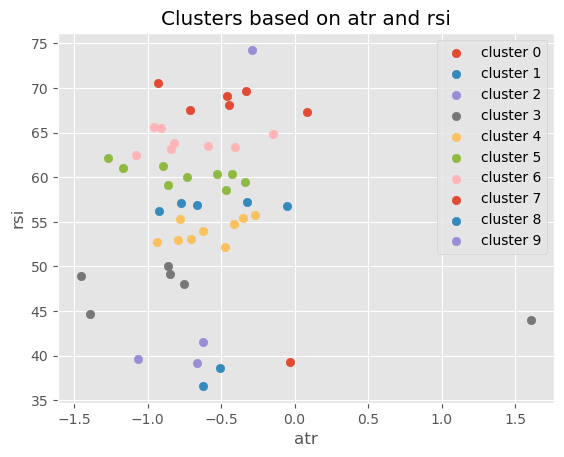

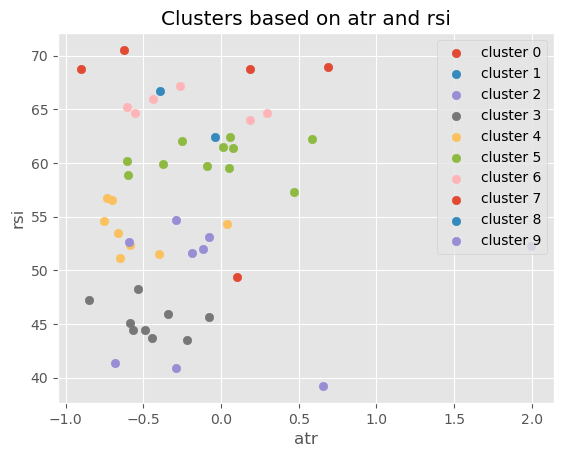

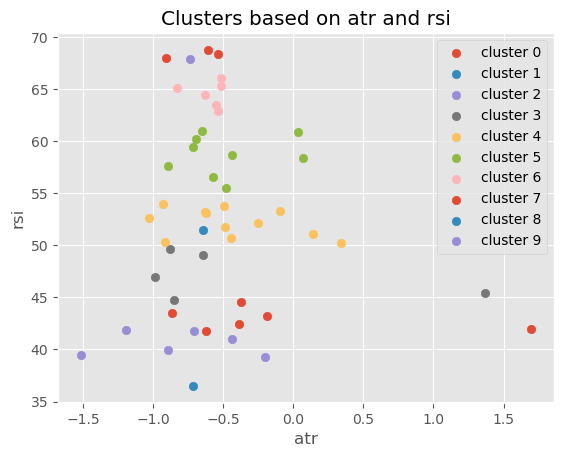

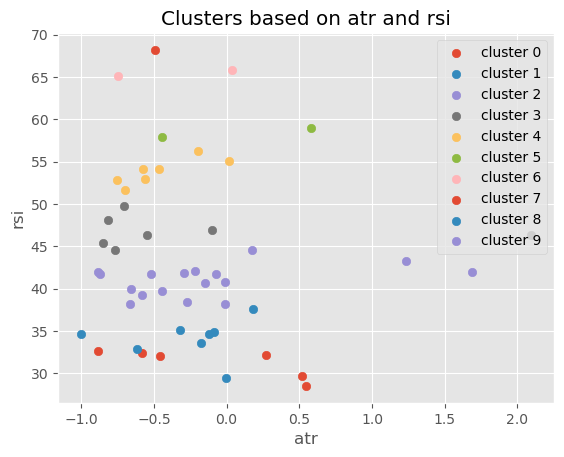

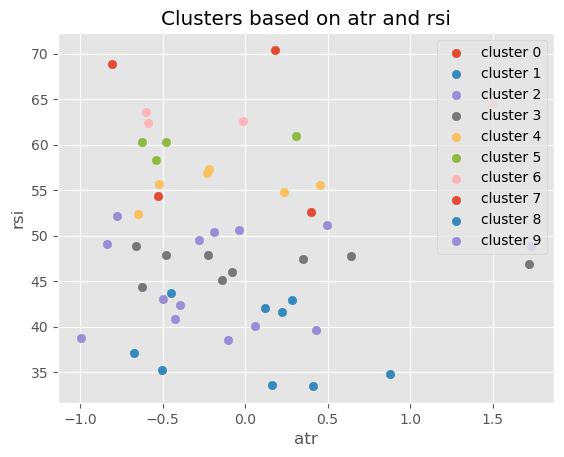

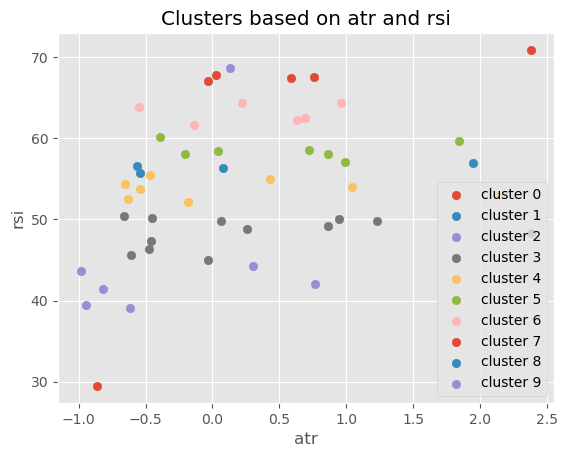

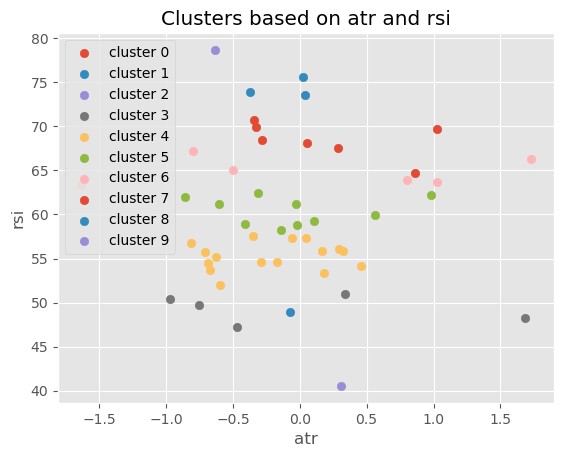

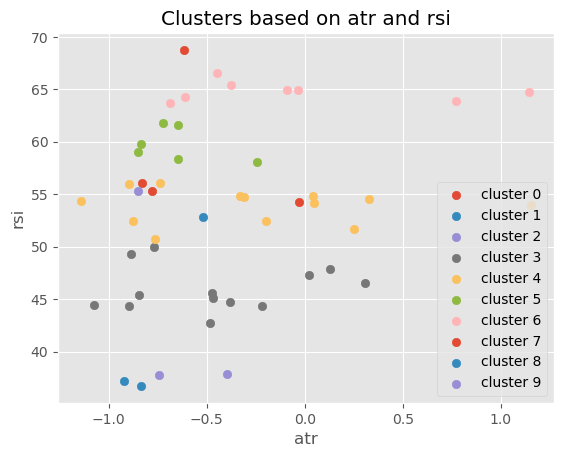

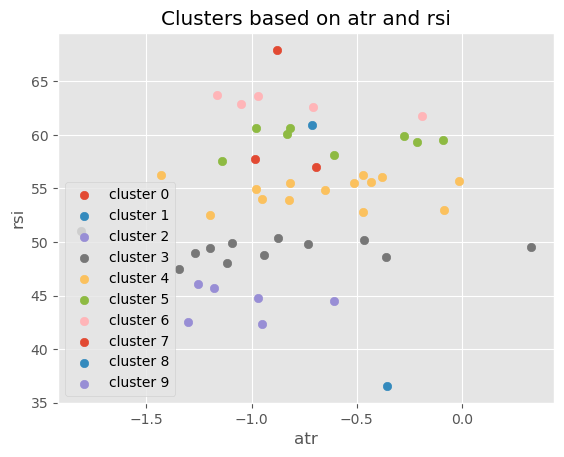

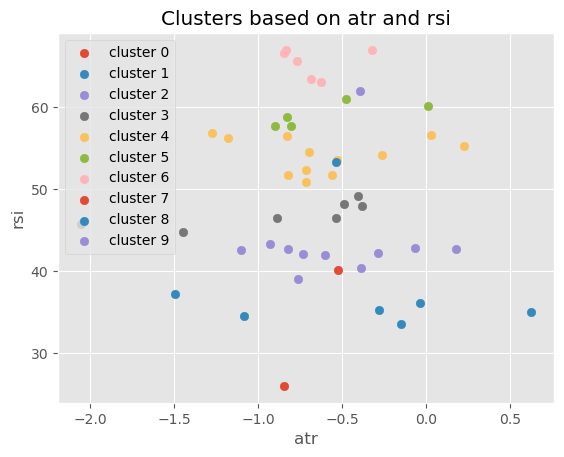

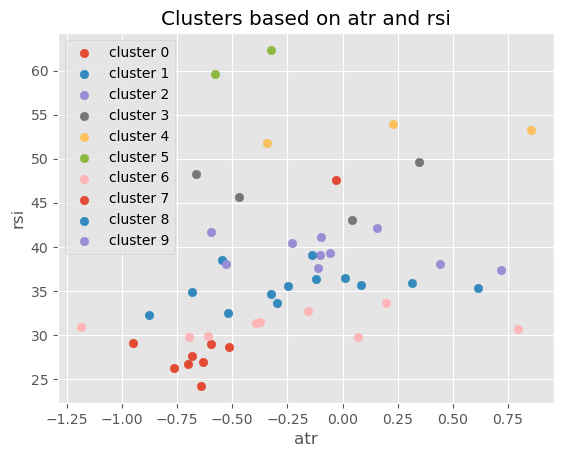

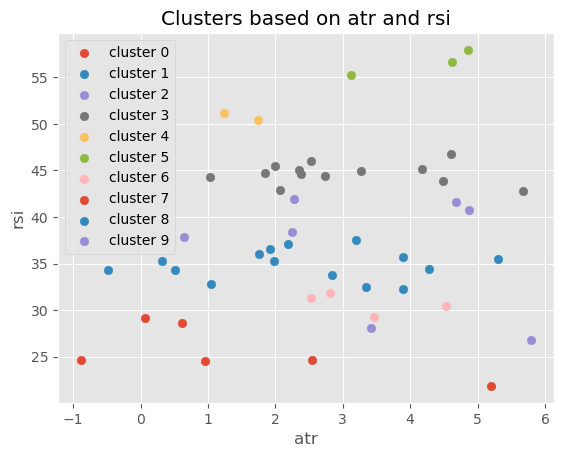

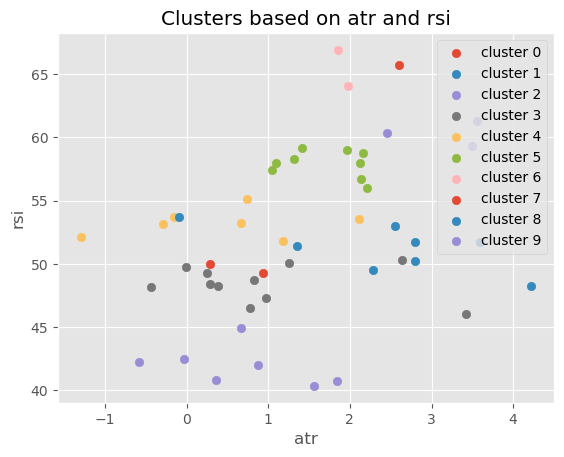

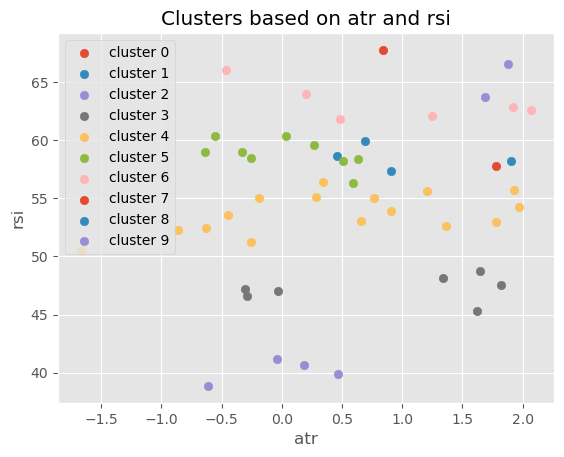

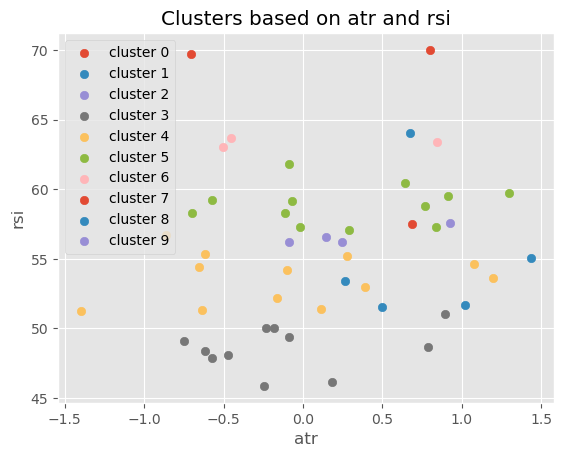

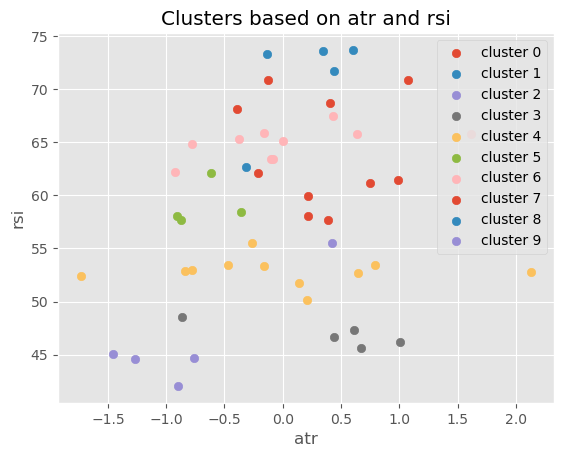

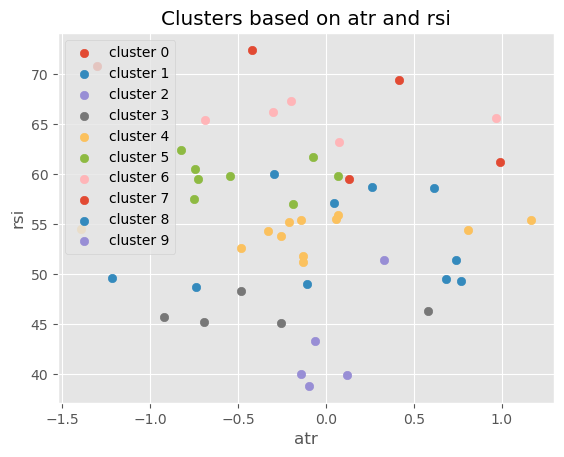

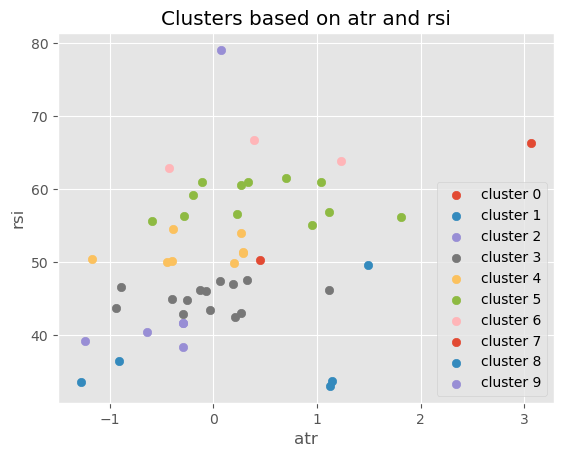

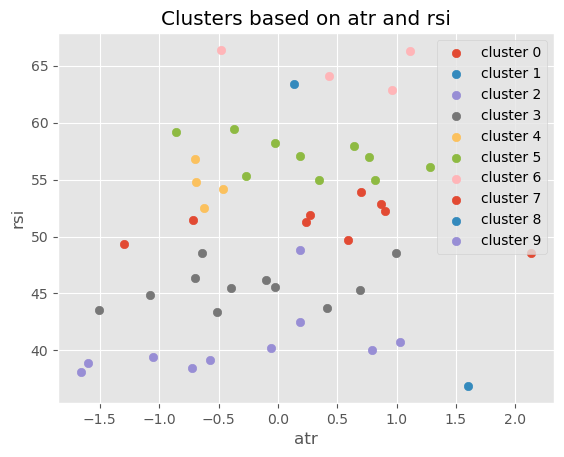

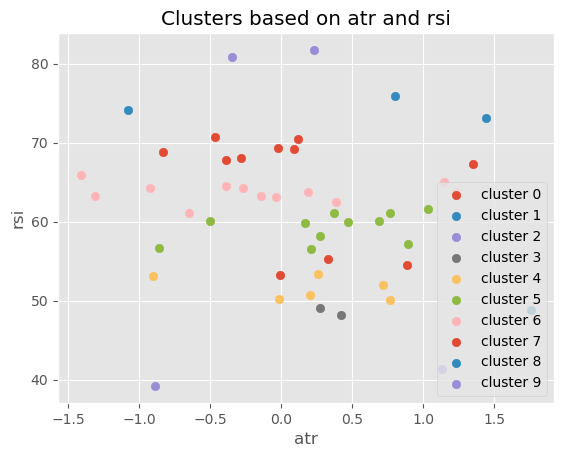

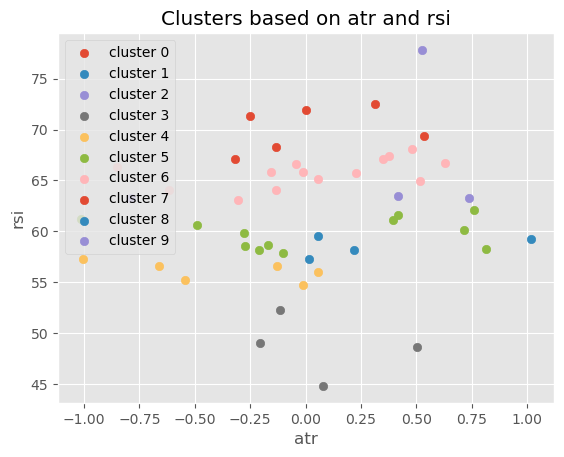

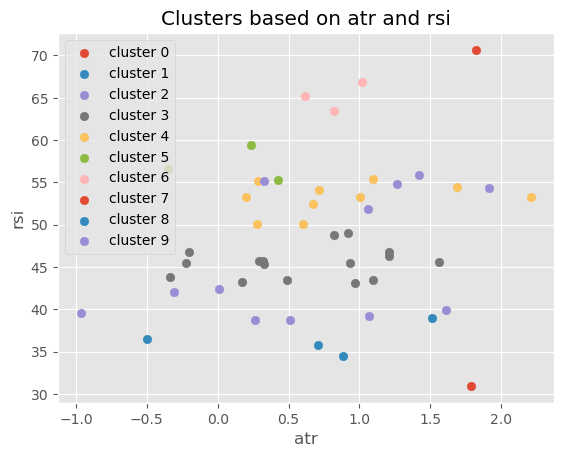

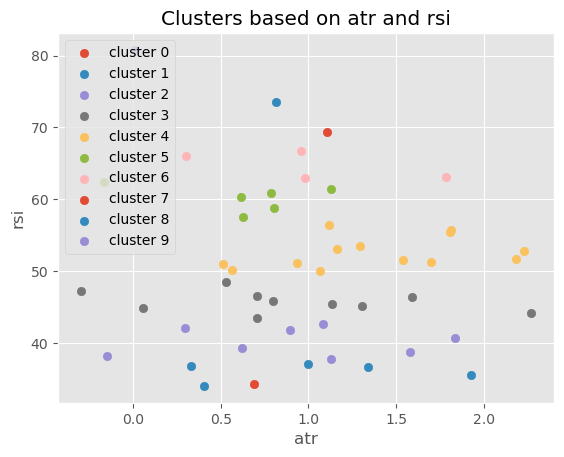

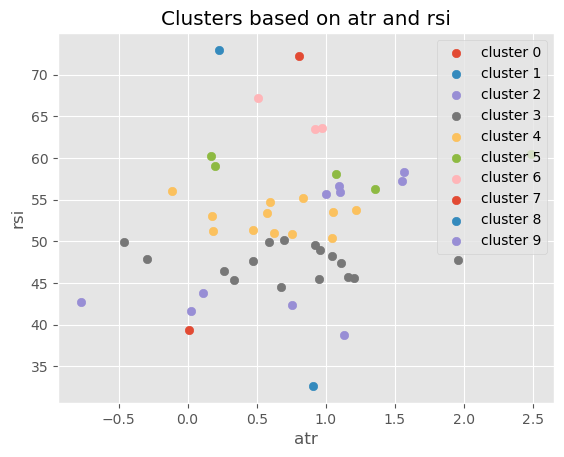

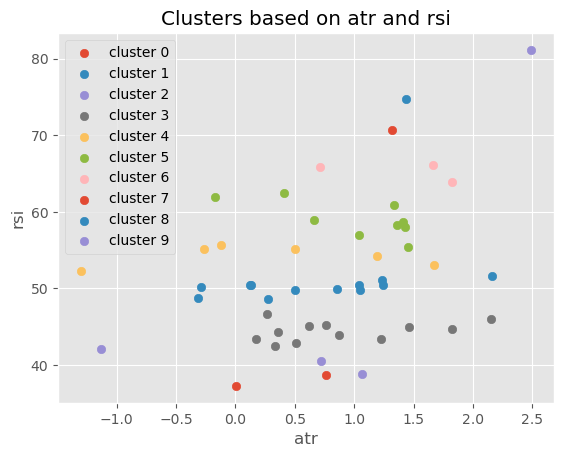

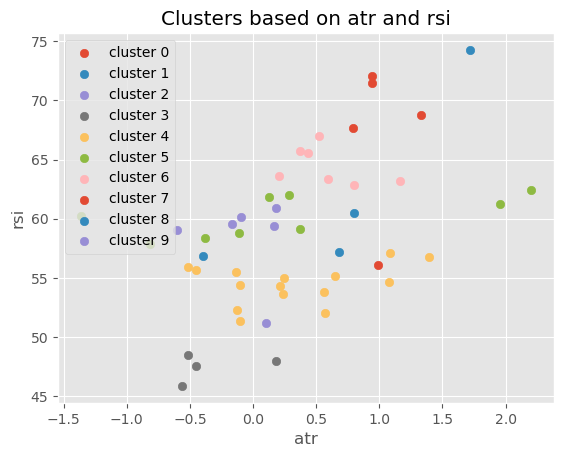

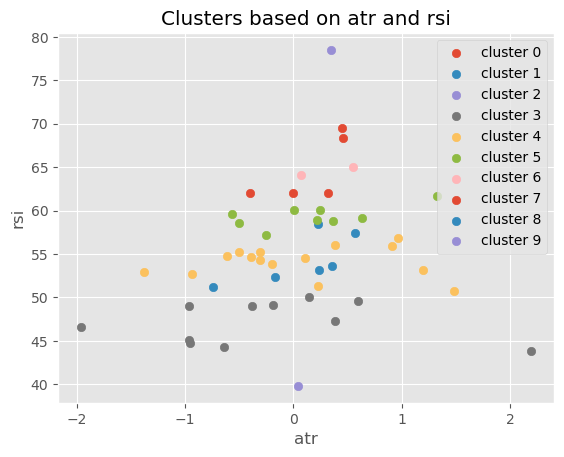

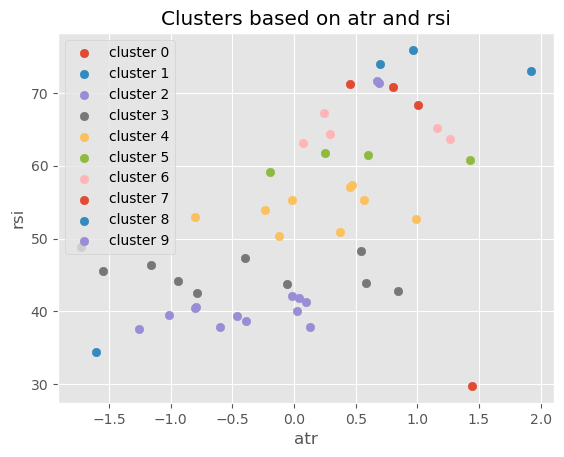

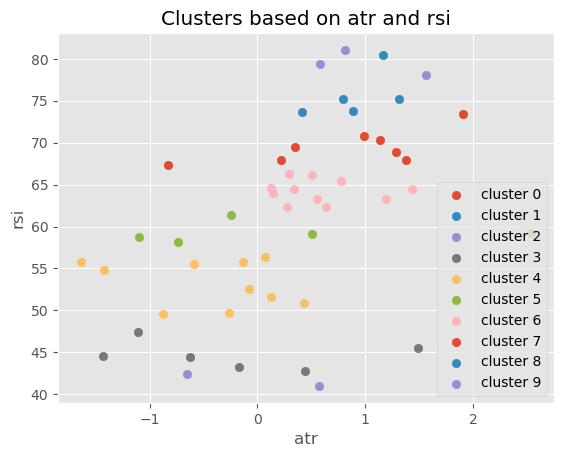

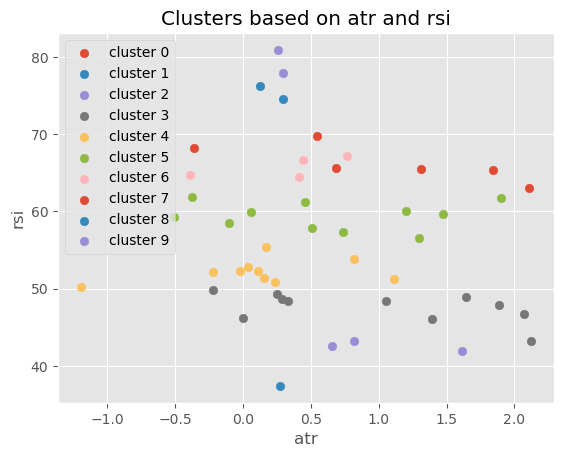

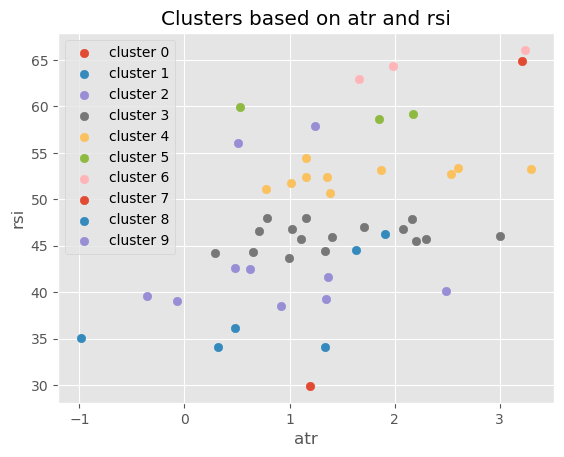

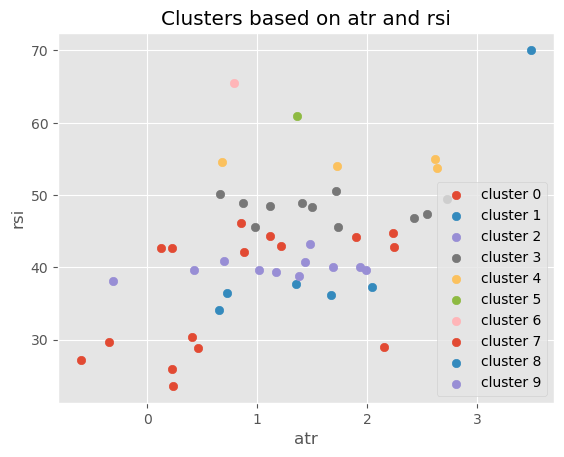

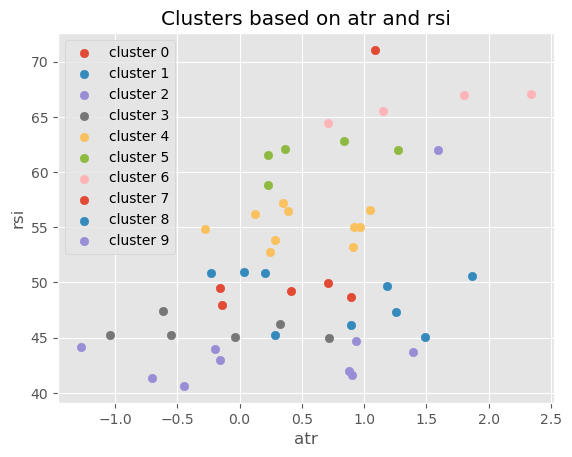

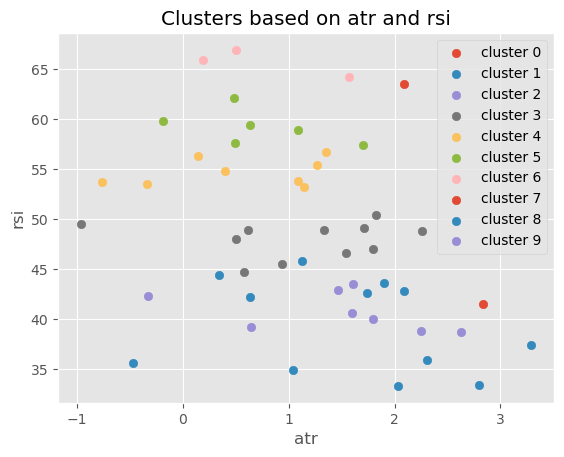

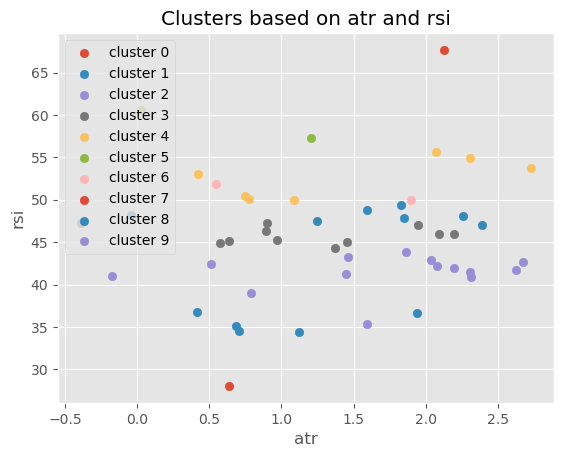

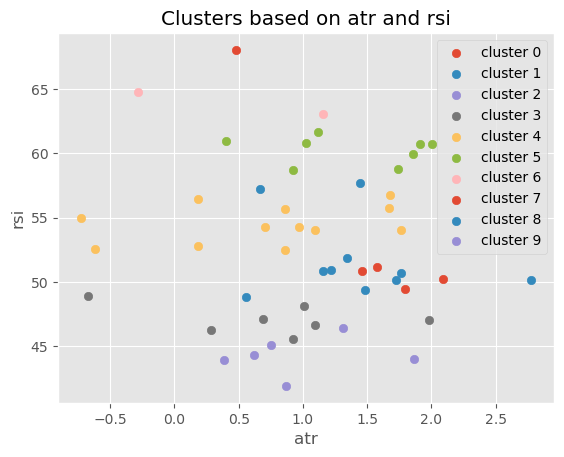

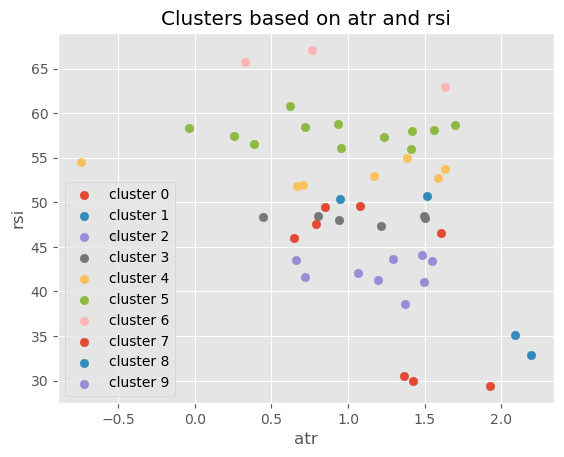

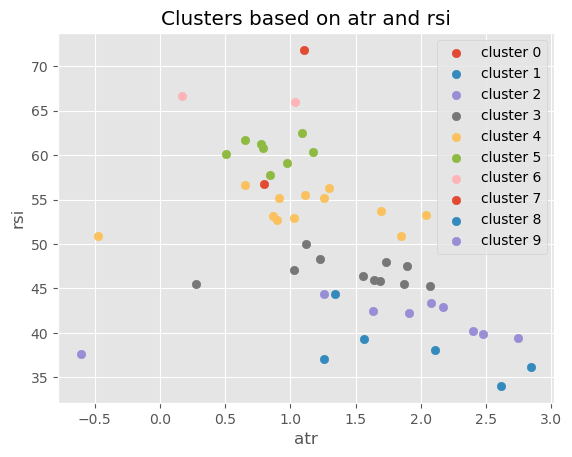

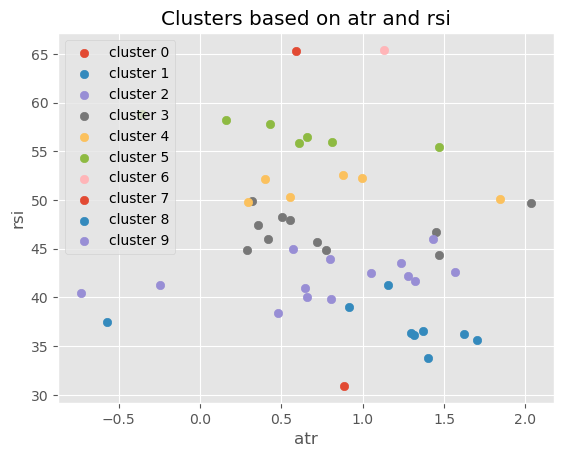

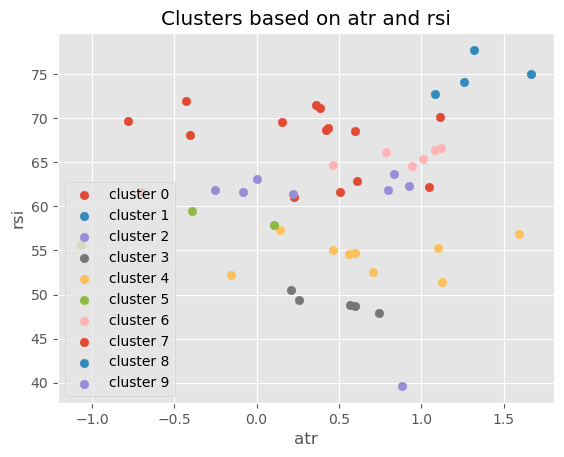

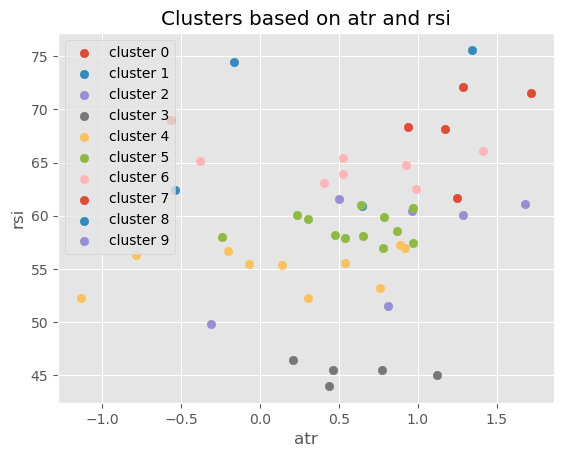

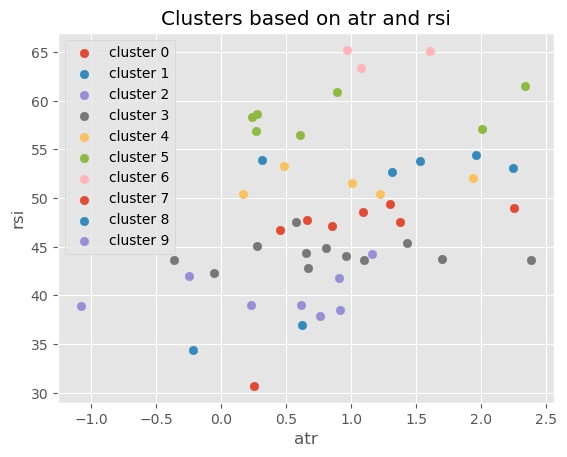

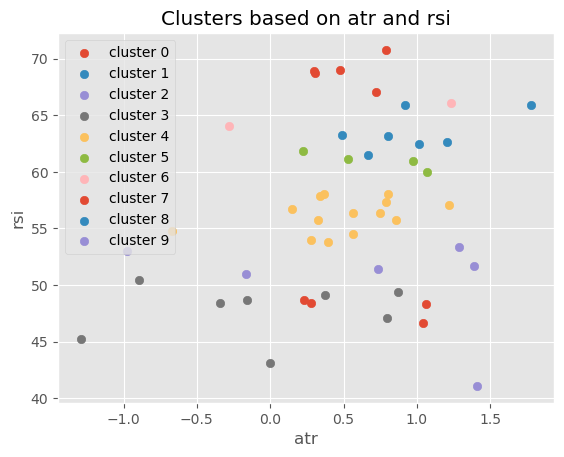

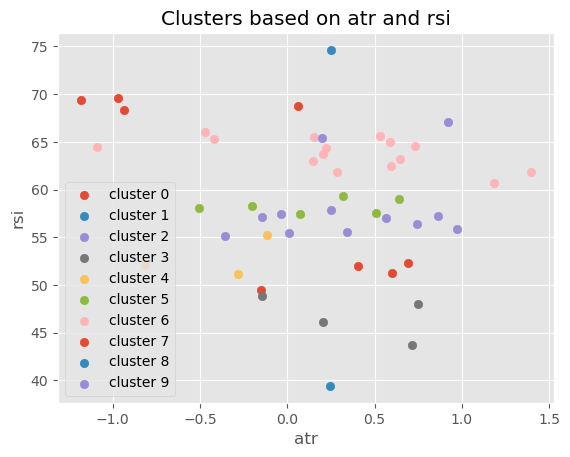

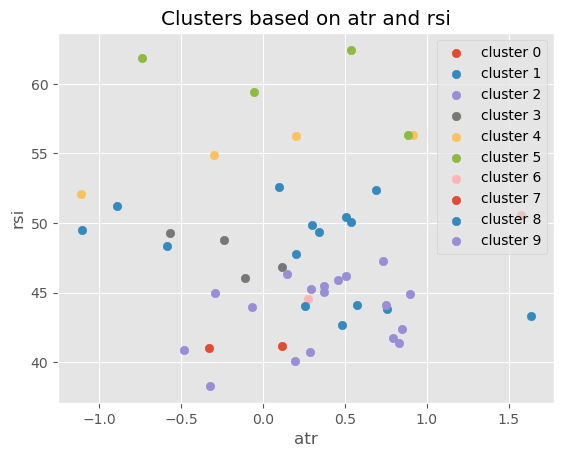

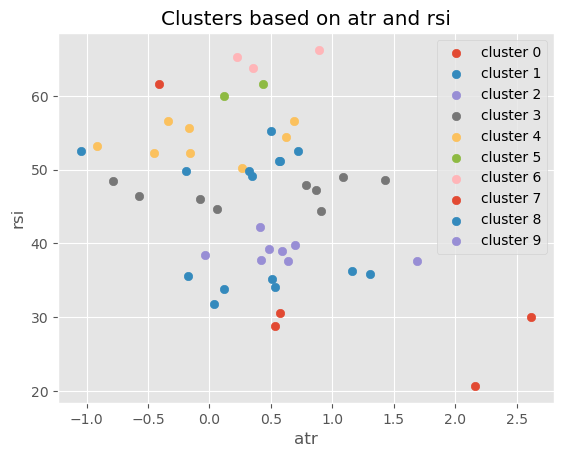

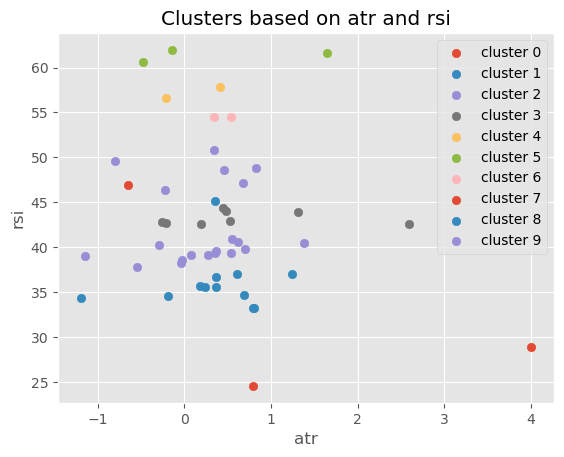

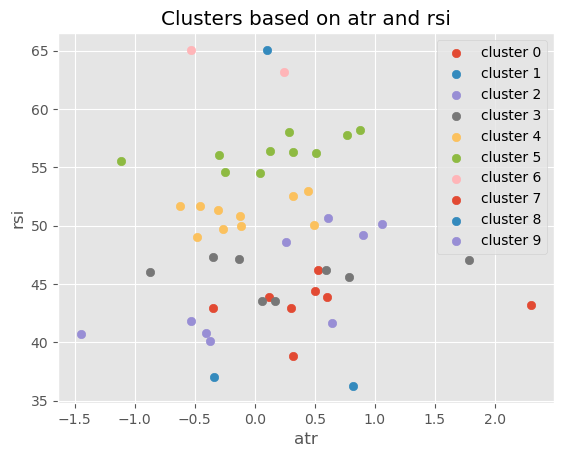

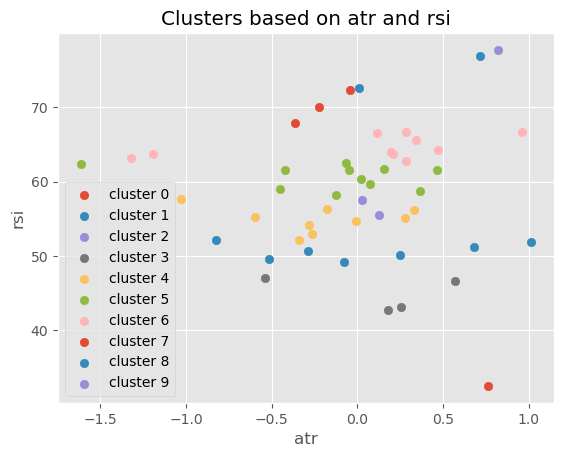

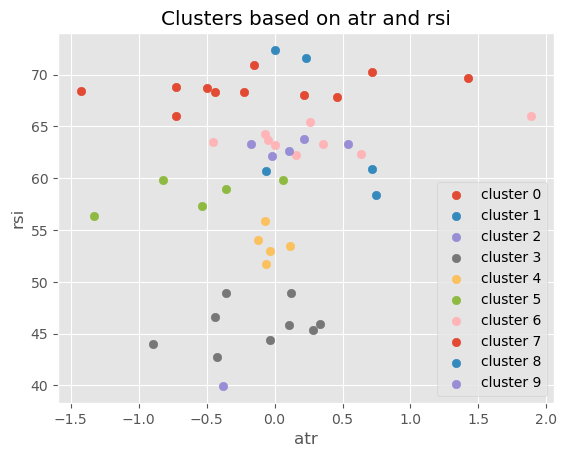

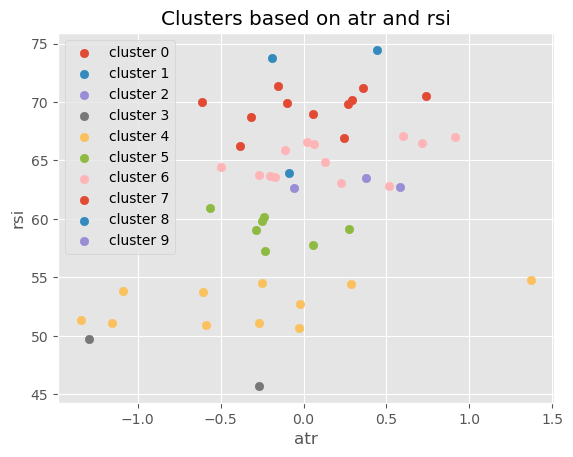

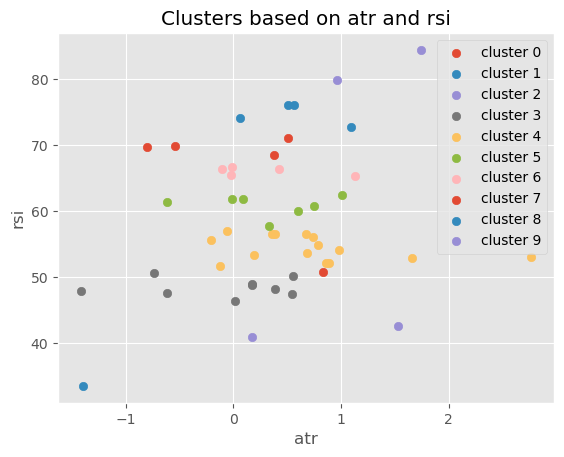

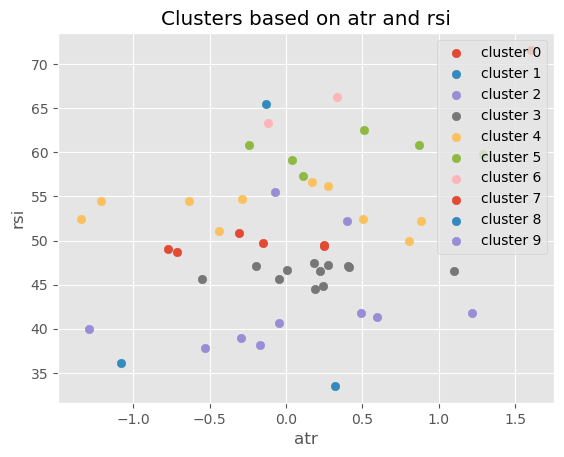

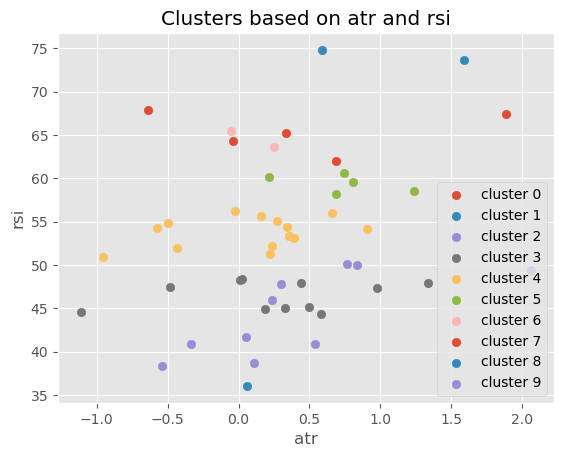

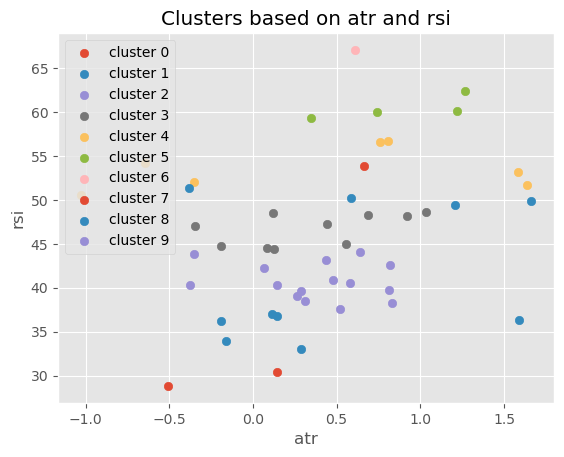

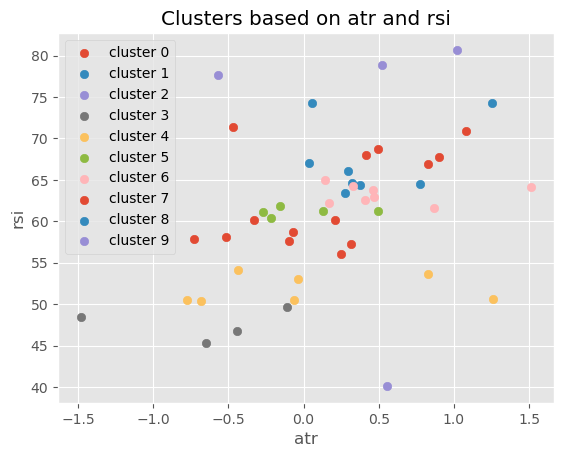

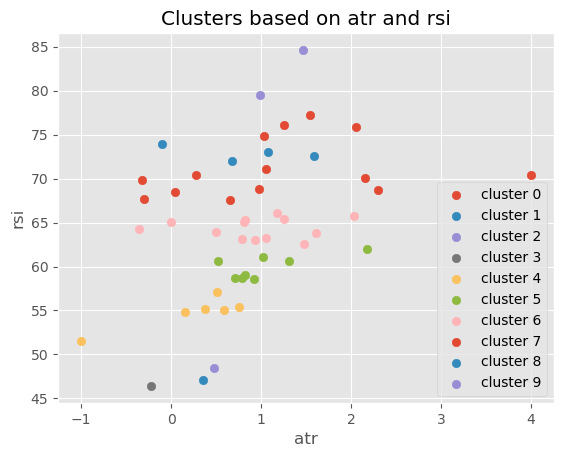

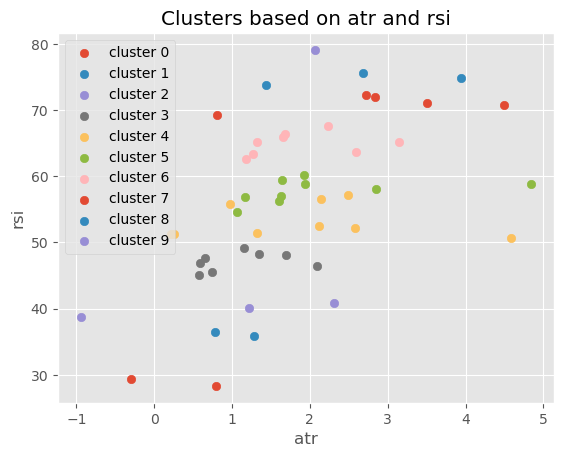

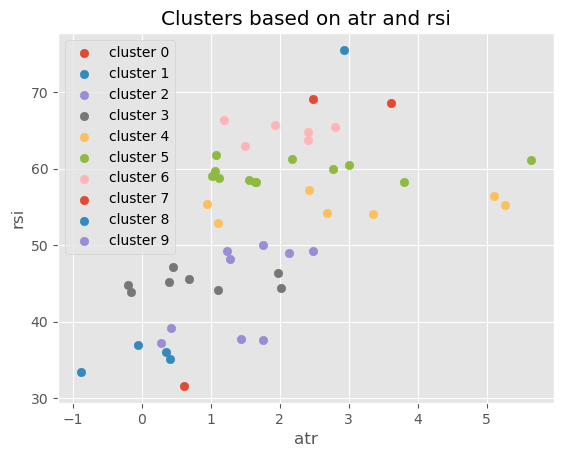

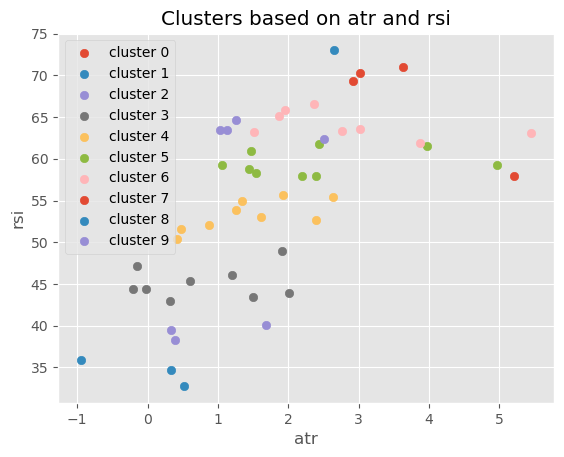

In [19]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [20]:
target_rsi_values = [30,35,40,45,55,60,65,70,75,80]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 80.,  0.,  0.,  0.,  0.,

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [42]:
filtered_df = data[data['cluster']==9].copy()  # eveything lies here so use cluster value carefull

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates


{'2017-05-01': ['ULTRACEMCO.NS'],
 '2017-06-01': ['HDFCBANK.NS'],
 '2017-07-01': ['ASIANPAINT.NS',
  'BAJAJ-AUTO.NS',
  'EICHERMOT.NS',
  'LT.NS',
  'M&M.NS',
  'TCS.NS',
  'ULTRACEMCO.NS'],
 '2017-08-01': ['BAJFINANCE.NS', 'HDFCBANK.NS'],
 '2017-09-01': ['ULTRACEMCO.NS'],
 '2017-10-01': ['ASIANPAINT.NS', 'ULTRACEMCO.NS'],
 '2017-11-01': ['DRREDDY.NS', 'EICHERMOT.NS', 'HEROMOTOCO.NS'],
 '2017-12-01': ['LTIM.NS'],
 '2018-01-01': ['BAJFINANCE.NS', 'BRITANNIA.NS', 'EICHERMOT.NS'],
 '2018-02-01': ['BAJAJ-AUTO.NS', 'MARUTI.NS'],
 '2018-03-01': ['ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'DRREDDY.NS',
  'HCLTECH.NS',
  'HDFCBANK.NS',
  'LT.NS',
  'UPL.NS'],
 '2018-04-01': ['HEROMOTOCO.NS', 'MARUTI.NS'],
 '2018-05-01': ['ASIANPAINT.NS',
  'CIPLA.NS',
  'DIVISLAB.NS',
  'EICHERMOT.NS',
  'INDUSINDBK.NS',
  'LTIM.NS',
  'TITAN.NS'],
 '2018-06-01': ['HEROMOTOCO.NS', 'MARUTI.NS'],
 '2018-07-01': ['AXISBANK.NS',
  'DIVISLAB.NS',
  'EICHERMOT.NS',
  'GRASIM.NS',
  'LT.NS',
  'TECHM.NS'],
 '2018-08-01': 

# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [22]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [23]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  50 of 50 completed


Adj Close                                            \
            ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2016-05-02    46.476776    223.721725   1274.432129    819.145813   
2016-05-03    45.862778    226.170715   1262.190796    825.965881   
2016-05-04    42.258888    200.000214   1274.529541    827.481140   
2016-05-05    41.698292    190.156265   1269.798950    821.277039   
2016-05-06    40.977509    186.842941   1299.841675    842.115723   
...                 ...           ...           ...           ...   
2024-03-07  3226.550049   1325.449951   6048.799805   2870.550049   
2024-03-11  3207.350098   1326.949951   6204.700195   2876.850098   
2024-03-12  3122.500000   1301.300049   6144.799805   2876.149902   
2024-03-13  2906.199951   1209.550049   6008.399902   2860.149902   
2024-03-14  3083.949951   1264.349976   6036.250000   2886.850098   

                                                                   \
            AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2016-05-02   461.133820   1950.243530    193.459091    689.413940   
2016-05-03   459.912079   1938.358887    194.146866    682.743347   
2016-05-04   451.995209   1936.352051    188.729523    679.684143   
2016-05-05   450.626831   1930.842896    188.191269    699.358643   
2016-05-06   451.017853   1916.597168    186.706116    710.007080   
...                 ...           ...           ...           ...   
2024-03-07  1111.449951   8879.049805   1582.800049   6421.049805   
2024-03-11  1105.099976   8659.400391   1598.800049   6433.750000   
2024-03-12  1097.000000   8527.700195   1593.550049   6436.049805   
2024-03-13  1080.400024   8384.900391   1573.150024   6456.149902   
2024-03-14  1075.500000   8396.000000   1575.400024   6460.000000   

                                      ...       Volume                \
           BHARTIARTL.NS     BPCL.NS  ... SUNPHARMA.NS TATACONSUM.NS   
Date                                  ...                              
2016-05-02    309.714722  206.415604  ...      1083227        717595   
2016-05-03    318.846893  203.083725  ...      5809209       1356187   
2016-05-04    312.874146  201.625397  ...      2523074        894057   
2016-05-05    306.771637  199.869019  ...      3065087        745000   
2016-05-06    310.839996  199.954132  ...      1464262        654231   
...                  ...         ...  ...          ...           ...   
2024-03-07   1199.699951  624.700012  ...      2440999       3522952   
2024-03-11   1196.599976  626.400024  ...      2994345       2609165   
2024-03-12   1204.250000  625.450012  ...      1294598       1089396   
2024-03-13   1168.750000  597.750000  ...      2881503       2050756   
2024-03-14   1186.699951  604.450012  ...      1543605       1119096   

                                                                  \
           TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS   
Date                                                               
2016-05-02       4178821     43887322  1116692  1076011   966084   
2016-05-03       9620804     66909161  2153118  1721645   963168   
2016-05-04      12069134     83523154  1364892  1379336  1040577   
2016-05-05       9601341     87494787  1246566  1484568  1448922   
2016-05-06       9953672     56288545   885598   948747  1508866   
...                  ...          ...      ...      ...      ...   
2024-03-07      16877082    124847699  2688905  2073691   838514   
2024-03-11       7502450     54155385  2304068  1577732   597848   
2024-03-12       8763820     34947937  4039801  1963068   564569   
2024-03-13      16564155     70937597  2837260  2001399  1027729   
2024-03-14      15942351     67081463  1411699   742963   659797   

                                             
           ULTRACEMCO.NS    UPL.NS WIPRO.NS  
Date                      

In [24]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-04-30 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [25]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-05-02         0.007126
2017-05-03         0.001908
2017-05-04        -0.007476
2017-05-05        -0.006016
2017-05-08         0.008344
...                     ...
2024-03-07         0.009477
2024-03-11         0.000853
2024-03-12        -0.003364
2024-03-13        -0.020566
2024-03-14         0.002685

[1700 rows x 1 columns]

<Axes: xlabel='date'>

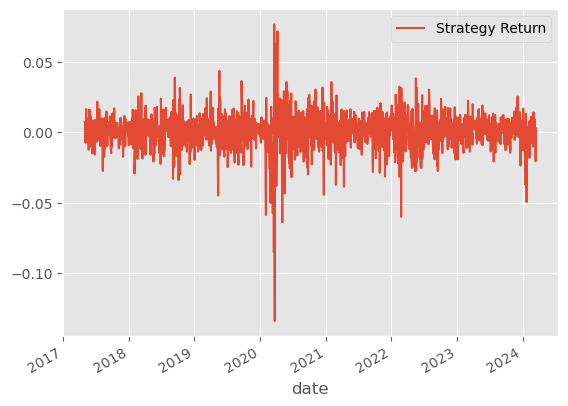

In [26]:
portfolio_df.plot()

In [27]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

APOLLOHOSP.NS  BRITANNIA.NS  EICHERMOT.NS  HDFCBANK.NS  HDFCLIFE.NS  \
0       0.111111      0.111111      0.111111     0.111111     0.111111   

   HINDALCO.NS  HINDUNILVR.NS  KOTAKBANK.NS  TECHM.NS  
0     0.111111       0.111111      0.111111  0.111111

In [28]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-05-02         0.007126        0.001047
2017-05-03         0.001908       -0.000199
2017-05-04        -0.007476        0.005136
2017-05-05        -0.006016       -0.008002
2017-05-08         0.008344        0.003092
...                     ...             ...
2024-03-06         0.001410        0.005253
2024-03-07         0.009477        0.000867
2024-03-11         0.000853       -0.007179
2024-03-12        -0.003364        0.000137
2024-03-13        -0.020566       -0.015248

[1695 rows x 2 columns]

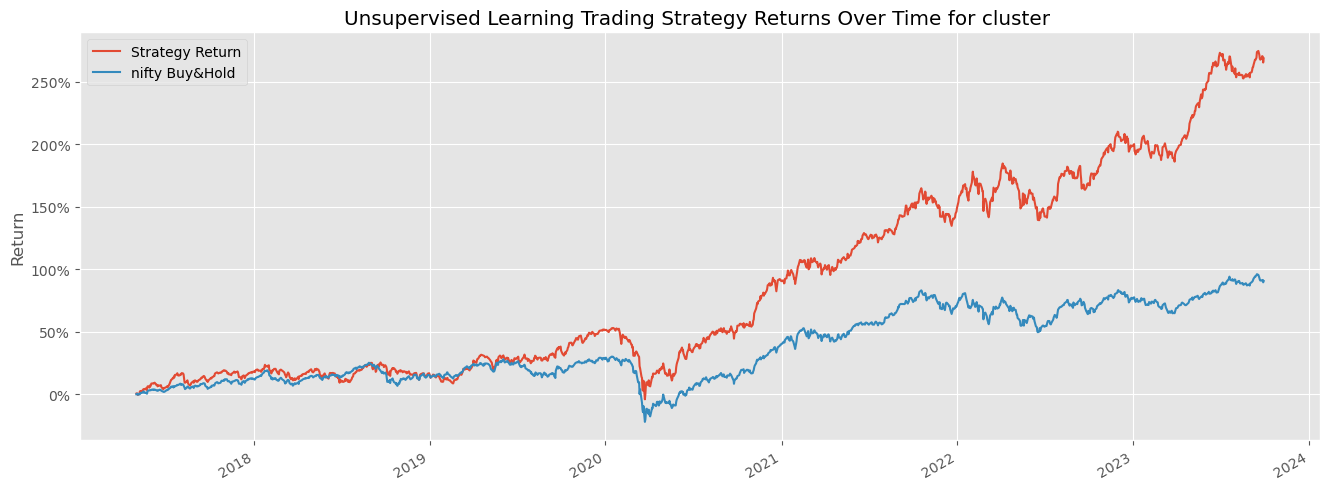

In [29]:
import matplotlib.ticker as mtick
unique_clusters = data['cluster'].unique()

for cluster_number in unique_clusters:
    filtered_df = data[data['cluster'] == cluster_number].copy()

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time for cluster ')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()




In [30]:
import numpy as np

# Assuming 'portfolio_df' has the 'Strategy Return' and 'nifty Buy&Hold' columns
strategy_returns = portfolio_df['Strategy Return']
nifty_returns = portfolio_df['nifty Buy&Hold']

# Calculate Sharpe ratio for the strategy
strategy_sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

# Calculate Sharpe ratio for NIFTY 50
nifty_sharpe_ratio = np.sqrt(252) * nifty_returns.mean() / nifty_returns.std()

# Print the Sharpe Ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")
print(f"NIFTY 50 Sharpe Ratio: {nifty_sharpe_ratio:.4f}")


Strategy Sharpe Ratio: 1.0763
NIFTY 50 Sharpe Ratio: 0.7307


In [31]:
# Given data
stock_data = {
    'BAJFINANCE': [7259.35, 7314.55, 0.760399],
    'ICICIBANK': [946.70, 1015.70, 7.28848],
    'INDUSINDBK': [1461.15, 1497.50, 2.48777],
    'ITC': [449.90, 453.10, 0.711269],
    'KOTAKBANK': [1750.50, 1824.35, 4.21879],
    'SBIN': [571.75, 612.40, 7.10975],
    'ASIANPAINT': [3173.40, 3243.65, 2.21371],
    'CIPLA': [1205.70, 1216.50, 0.895745],
    'TCS': [3511.65, 3593.55, 2.33224],
    'UPL': [575.15, 599.35, 4.2076]
}

# Calculating total increase
total_increase = sum(stock[2] for stock in stock_data.values())

# Displaying the total increase
print(f'Total Increase: {total_increase:.2f}%')

Total Increase: 32.23%


In [32]:
apar= yf.download('APARINDS.NS',start="2010-01-01",end="2024-02-01")

[*********************100%%**********************]  1 of 1 completed
